# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. 

Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**План анализа:**
1. Открытие и общий обзор данных.
2. Предобработка данных.
    - пропущенные значения;
    - типы данных;
    - дубликаты;
    - выбросы.
3. Добавление дополнительной информации.
4. Исследовательский анализ данных.
    - изучение параметров объектов;
    - скорость продажи;
    - влияние факторов на стоимость;
    - средняя цена квадратного метра в 10 населенных пунктах с наибольшим количеством объявлений;
    - средняя цена удаления на 1 км от центра Санкт-Петербурга.
5. Вывод.

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('real_estate_data.csv', sep='\t')
display(data.sample(3)) #образец данных для проверки разделителя

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
20354,0,4800000.0,59.00,2016-04-07T00:00:00,2,NaN,7.0,33.50,1,NaN,...,11.00,0.0,Санкт-Петербург,14719.0,15491.0,1.0,638.0,0.0,NaN,341.0
14483,4,7580000.0,53.72,2017-05-05T00:00:00,2,2.8,24.0,29.21,2,False,...,10.52,0.0,Санкт-Петербург,9354.0,13149.0,1.0,541.0,1.0,333.0,38.0
10583,10,6700000.0,67.00,2019-03-21T00:00:00,2,3.0,5.0,43.00,3,NaN,...,10.00,NaN,Санкт-Петербург,21609.0,5340.0,1.0,371.0,3.0,362.0,13.0


In [3]:
print(data.shape)
data.info() #общая информация о данных

(23699, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airport

In [4]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


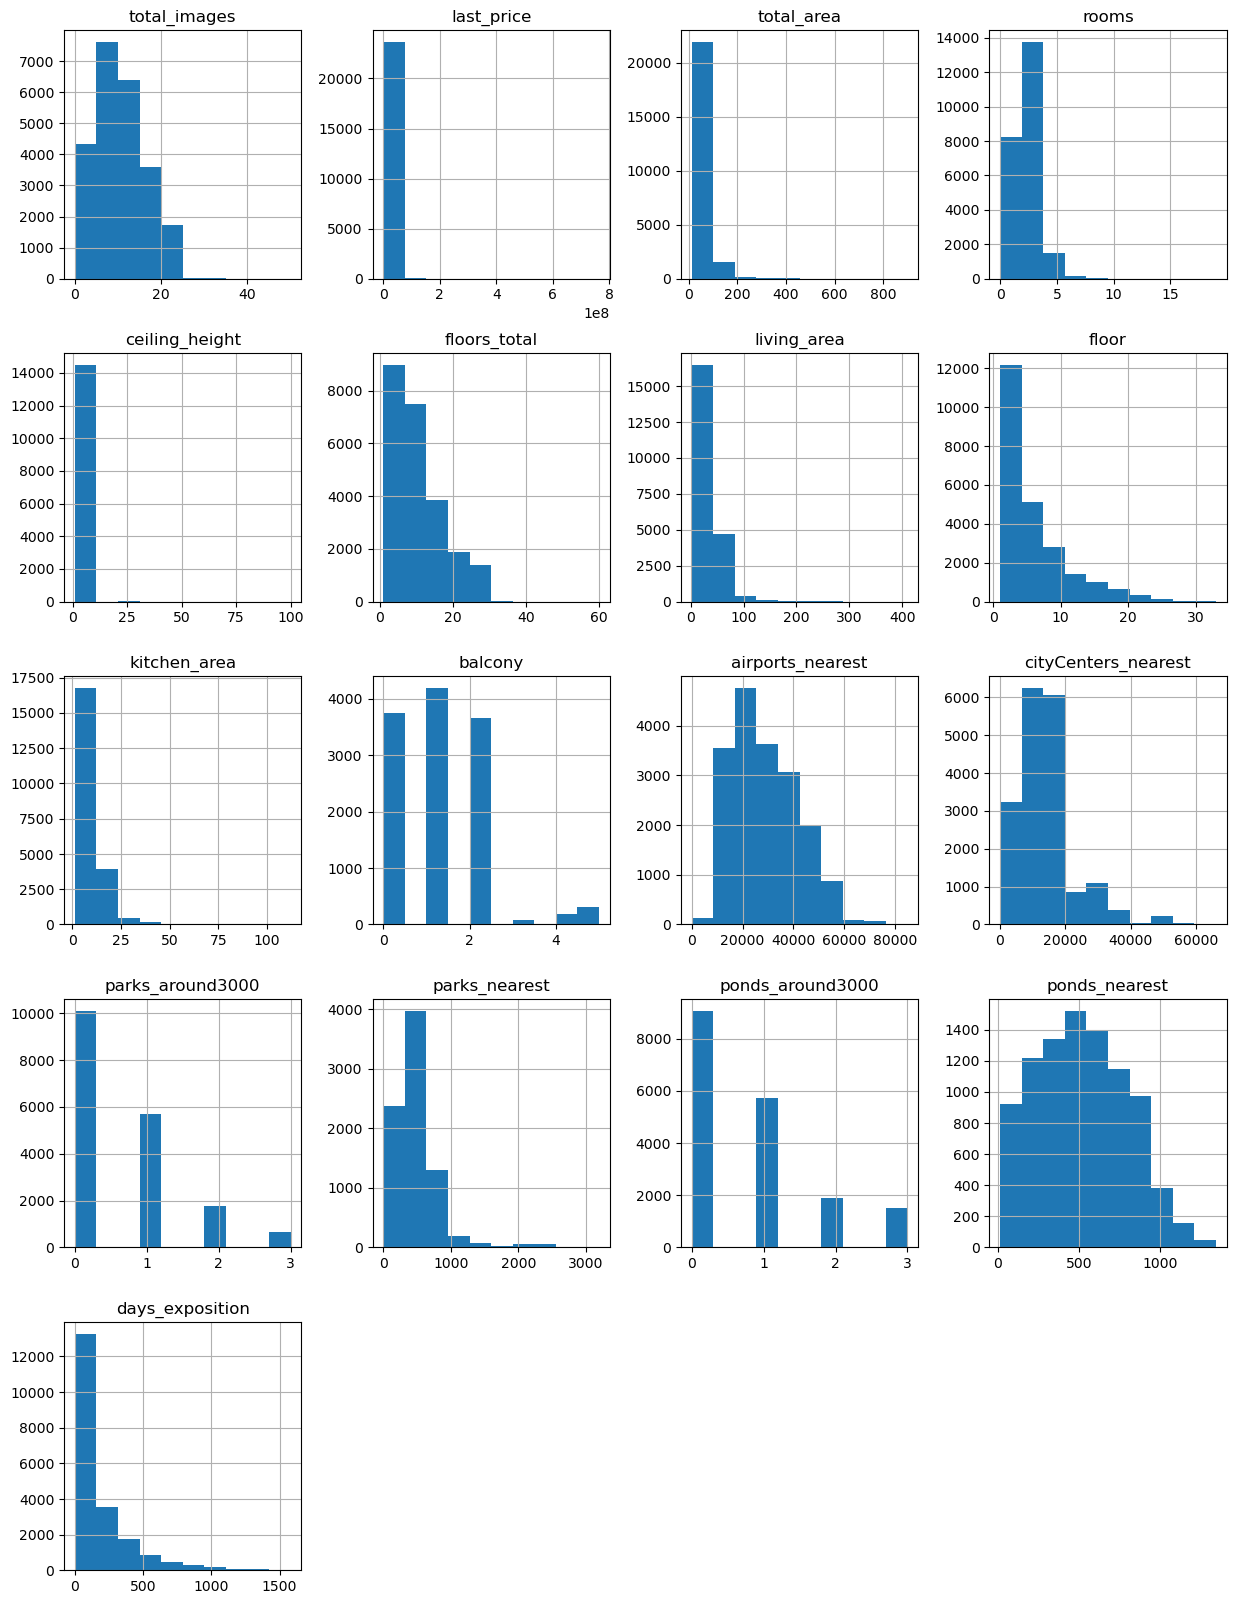

In [5]:
data.hist(figsize=(15,20)); #распределение значений на гистограммах (x=значение, y=количество)

### Предобработка данных

#### Обработка пропущенных значений

In [6]:
print(data.isna().sum()) #количество пропусков

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


In [7]:
# пропущенные значения в виде графика

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = 0, legend = False, fontsize = 16)
            .set_title('Пропуски' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('Пропусков не осталось')

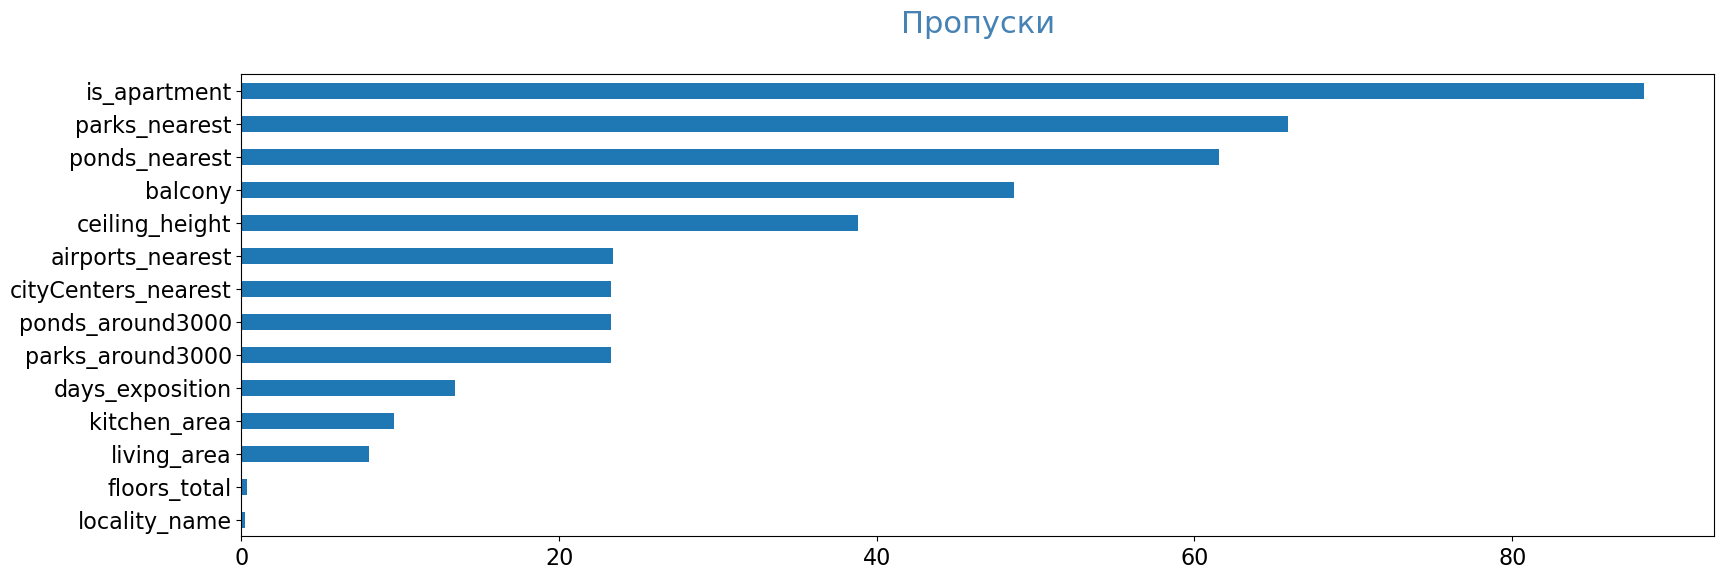

In [8]:
pass_value_barh(data)

In [9]:
df = data.copy() #создании копии data для последующей обработки

##### ceiling_height (высота потолков (м))

In [10]:
print('Количество пропусков: {}'.format(
    data['ceiling_height'].isna().sum()))

Количество пропусков: 9195


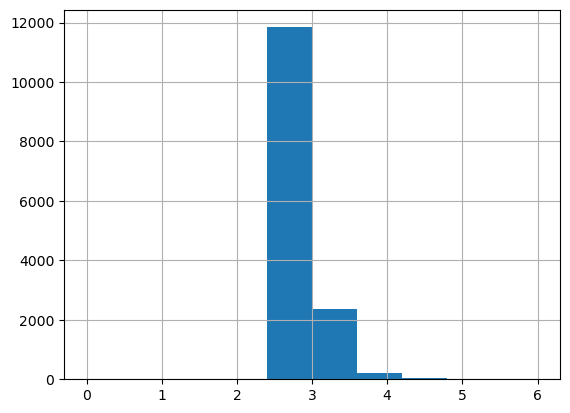

In [11]:
#df['ceiling_height'].value_counts()
df['ceiling_height'].hist(bins=10, range=(0,6));

In [12]:
print(df['ceiling_height'].median())
print(df[df['ceiling_height']<6]['ceiling_height'].median()) #влияние выбросов на медиану

2.65
2.65


Выбросы не оказывают значимого влияния на медиану.<br>
Возможные причины появления пропусков: отсутствие информации о точной высоте потолков.<br>
Заполнение пропусков: медиана.

In [13]:
df['ceiling_height'] = df['ceiling_height'].fillna(
    df['ceiling_height'].median()) #заполнение пропусков
print(df['ceiling_height'].isna().sum()) #проверка заполнения пропущенных значений

0


##### floors_total (всего этажей в доме)

In [14]:
print('Количество пропусков: {}'.format(
    data['floors_total'].isna().sum()))

Количество пропусков: 86


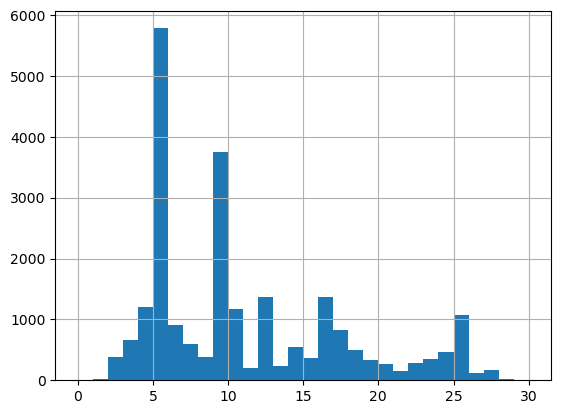

In [15]:
#df['floors_total'].value_counts()
df['floors_total'].hist(bins=30, range=(0,30));

Основные этажности домов: 5, 9, 12, 17, 26

In [16]:
print(df[df['floors_total'].isna()]['floor'].value_counts()) #этаж квартир с пропущенным значением этажности дома
print('max:', df[df['floors_total'].isna()]['floor'].max(), 'этаж')

4     10
6      9
8      8
12     6
9      5
21     4
5      4
7      4
3      4
19     3
11     3
13     3
1      3
18     3
15     3
10     3
24     2
2      2
20     2
14     2
22     1
17     1
23     1
Name: floor, dtype: int64
max: 24 этаж


Заполнение пропусков: типовая этажность 5, 9, 12, 17, 26. Для заполнения сравнить с этажом квартиры.

In [17]:
#функция возвращает этажность дома в зависимости от этажа квартиры
def floor_func(row):
    floor = row['floor']
    try:
        if floor <= 5:
            return 5
        elif floor <=9:
            return 9
        elif floor <=12:
            return 12
        elif floor <= 17:
            return 17
        elif floor <= 26:
            return 26
    except:
        return floor

In [18]:
df[185:188] #для дальнейшей проверки

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
185,8,8500000.0,49.9,2018-10-20T00:00:00,1,3.00,16.0,18.9,14,NaN,...,10.6,NaN,Санкт-Петербург,12114.0,8946.0,1.0,749.0,1.0,833.0,145.0
186,12,11640000.0,65.2,2018-10-02T00:00:00,2,2.65,NaN,30.8,4,NaN,...,12.0,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
187,9,4300000.0,52.3,2017-10-06T00:00:00,2,2.65,12.0,29.8,4,NaN,...,10.9,NaN,Санкт-Петербург,32794.0,13643.0,0.0,NaN,0.0,NaN,69.0


In [19]:
#заполнение пропусков
for index, row in df[df['floors_total'].isna()].iterrows():
    df.loc[index, 'floors_total'] = floor_func(row)

display(df[185:188]) #проверка заполнения строки 186
print(df['floors_total'].isna().sum()) #проверка заполнения пропущенных значений пропусков

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
185,8,8500000.0,49.9,2018-10-20T00:00:00,1,3.00,16.0,18.9,14,NaN,...,10.6,NaN,Санкт-Петербург,12114.0,8946.0,1.0,749.0,1.0,833.0,145.0
186,12,11640000.0,65.2,2018-10-02T00:00:00,2,2.65,5.0,30.8,4,NaN,...,12.0,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
187,9,4300000.0,52.3,2017-10-06T00:00:00,2,2.65,12.0,29.8,4,NaN,...,10.9,NaN,Санкт-Петербург,32794.0,13643.0,0.0,NaN,0.0,NaN,69.0


0


##### living_area (жилая площадь в квадратных метрах (м²))

In [20]:
print('Количество пропусков: {}'.format(
    data['living_area'].isna().sum()))

Количество пропусков: 1903


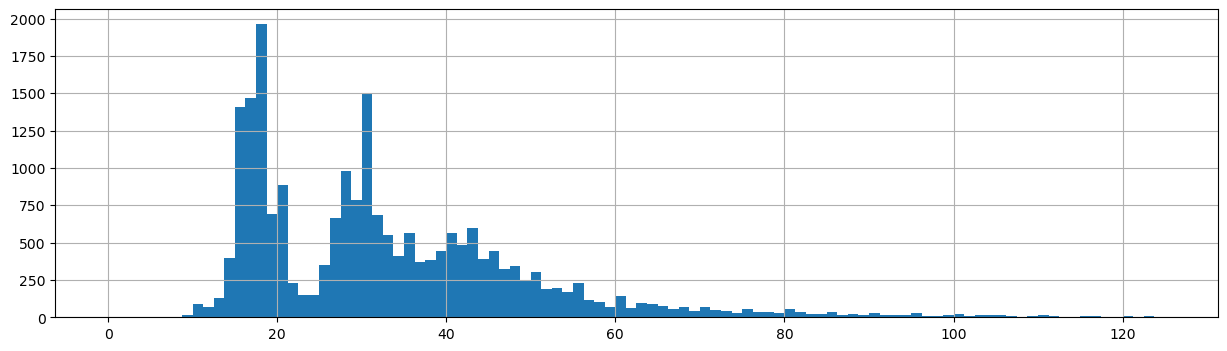

In [21]:
#print(df['living_area'].value_counts())
df['living_area'].hist(bins=100, range=(0,125), figsize=(15,4)); # распределение жилой площади

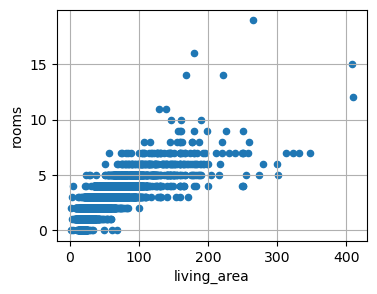

In [22]:
# зависимость жилой площади от количества комнат
df.plot(x='living_area', y='rooms', kind='scatter', grid=True, figsize=(4,3)); 

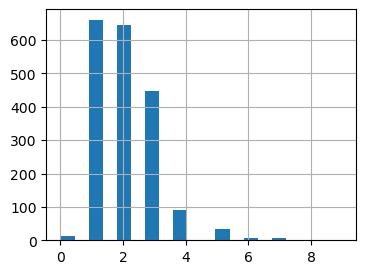

In [23]:
#распределение комнат в выборке с отутствующей жилой площадью
df[df['living_area'].isna()]['rooms'].hist(bins=20, figsize=(4,3)); 

In [24]:
print('Количество квартир с кол-вом комнат >3, всего:', len(df[df['rooms']>3]))
print('Количество квартир с кол-вом комнат >3, без указания жилой площади:', 
      len(df[(df['rooms']>3)&(df['living_area'].isna())]))

Количество квартир с кол-вом комнат >3, всего: 1701
Количество квартир с кол-вом комнат >3, без указания жилой площади: 138


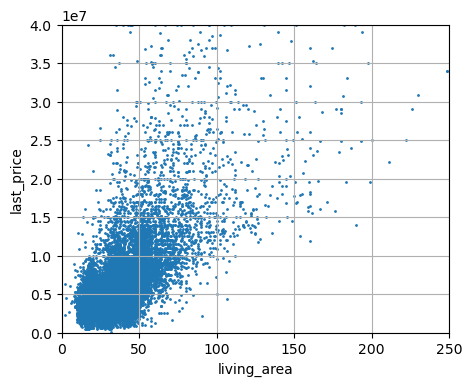

In [25]:
# зависимость жилой площади от цены
df.plot(x='living_area', y='last_price', kind='scatter', 
        grid=True, xlim=[0,250], ylim=[0,40000000], s=1, figsize=(5,4));

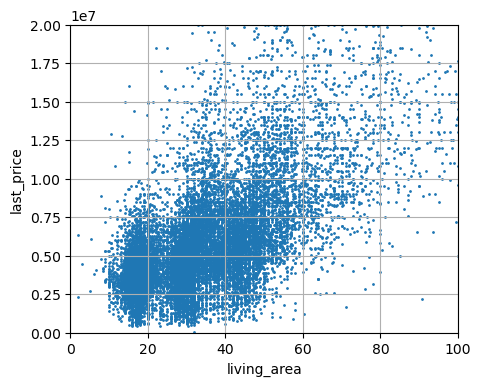

In [26]:
# зависимость жилой площади от цены
df.plot(x='living_area', y='last_price', kind='scatter', 
        grid=True, xlim=[0,100], ylim=[0,20000000], s=1, figsize=(5,4));

In [27]:
len(df[df['living_area']>150])

119

In [28]:
len(df[df['last_price']>40000000])

182

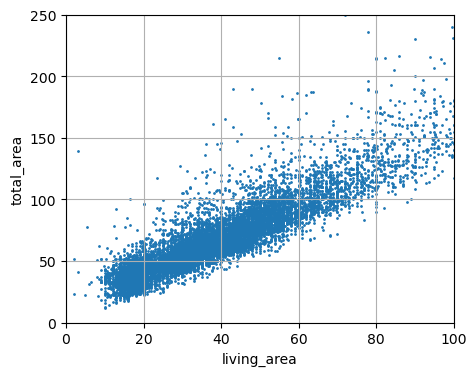

In [29]:
# зависимость жилой площади от общей
df.plot(x='living_area', y='total_area', kind='scatter', 
        grid=True, xlim=[0,100], ylim=[0,250], s=1, figsize=(5,4)); 

In [30]:
# проверка - сумма жилой площади и площади кухни <= 90% от общей
def test_90(row):
    return row['total_area']*0.9 <= (row['living_area'] + row['kitchen_area'])

In [31]:
df.apply(test_90, axis=1).sum()

475

In [32]:
# >100%
def test_100(row):
    return row['total_area'] < (row['living_area'] + row['kitchen_area'])

In [33]:
df.apply(test_100, axis=1).sum()

64

Пропущенные значения общей площади заполним медианным значением с коэффициентом 0,9 для групп по общей площади: 0-25, 25-35, 35-50, 50-60, 60-80, 80-100, 100-125, 125+ кв.м.<br>

Понижающий коэффициент добавлен в целях уменьшения количества аномалий, при которых сумма жилой площади и площади кухни составляет слишком большую долю от общей площади квартиры или превышает её.

In [34]:
#функция возвращает медианную жилую площадь в зависимости от общей площади
def liv_func(row):
    area = row['total_area']
    try:
        if area <= 25:
            return df[df['total_area'] <= 25]['living_area'].median()*0.9
        elif area <= 35:
            return df[(df['total_area'] > 25)&(
                df['total_area'] <= 35)]['living_area'].median()*0.9
        elif area <=50:
            return df[(df['total_area'] > 35)&(
                df['total_area'] <= 50)]['living_area'].median()*0.9
        elif area <=60:
            return df[(df['total_area'] > 50)&(
                df['total_area'] <= 60)]['living_area'].median()*0.9
        elif area <=80:
            return df[(df['total_area'] > 60)&(
                df['total_area'] <= 80)]['living_area'].median()*0.9
        elif area <=100:
            return df[(df['total_area'] > 80)&(
                df['total_area'] <= 100)]['living_area'].median()*0.9
        elif area <=125:
            return df[(df['total_area'] > 100)&(
                df['total_area'] <= 125)]['living_area'].median()*0.9
        elif area > 125:
            return df[df['total_area'] > 125]['living_area'].median()*0.9
    except:
        return df['living_area'].median()*0.9

In [35]:
#display(df[df['living_area'].isna()].head())
df[2:8] #для дальнейшей проверки

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.4,2018-09-10T00:00:00,1,2.65,12.0,14.4,5,NaN,...,9.1,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.3,2017-11-02T00:00:00,1,2.65,26.0,10.6,6,NaN,...,14.4,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,2.65,24.0,NaN,22,NaN,...,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN


In [36]:
#заполнение пропусков
for index, row in df[df['living_area'].isna()].iterrows():
    df.loc[index, 'living_area'] = liv_func(row)

display(df[2:8]) #проверка заполнения строк 3, 7
print(df['living_area'].isna().sum()) #проверка заполнения пропущенных значений

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,85.5,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.4,2018-09-10T00:00:00,1,2.65,12.0,14.4,5,NaN,...,9.1,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.3,2017-11-02T00:00:00,1,2.65,26.0,10.6,6,NaN,...,14.4,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,2.65,24.0,37.8,22,NaN,...,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN


0


In [37]:
# проверим, как сильно выросло кол-во квартир, не проходящих проверки
print(df.apply(test_90, axis=1).sum())
print(df.apply(test_100, axis=1).sum())

490
66


##### is_apartment (апартаменты)

In [38]:
print('Количество пропусков: {}'.format(
    data['is_apartment'].isna().sum()))

Количество пропусков: 20924


In [39]:
df['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

In [40]:
display(df[~df['is_apartment'].isna()].head(3))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
11,9,3300000.0,44.0,2018-08-27T00:00:00,2,2.65,5.0,31.0,4,False,...,6.0,1.0,Ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7.0
25,3,6800000.0,76.0,2015-10-01T00:00:00,2,2.75,23.0,39.0,18,False,...,15.0,2.0,Санкт-Петербург,34967.0,14640.0,0.0,NaN,1.0,564.0,300.0
29,9,8600000.0,100.0,2016-04-09T00:00:00,3,2.65,19.0,52.0,15,False,...,11.0,0.0,Санкт-Петербург,30394.0,11526.0,1.0,532.0,1.0,896.0,125.0


В столбце 'is_apartment' хранятся логические значения. <br>
Пропуск может означать, что квартира не является апартаментами. Следовательно, заполним пропуски значением False.

In [41]:
df['is_apartment'] = df['is_apartment'].fillna(False)

In [42]:
display(df['is_apartment'].value_counts())
print(df['living_area'].isna().sum()) #проверка заполнения пропущенных значений

False    23649
True        50
Name: is_apartment, dtype: int64

0


##### kitchen_area (площадь кухни в квадратных метрах (м²))

In [43]:
print('Количество пропусков: {}'.format(
    data['kitchen_area'].isna().sum()))

Количество пропусков: 2278


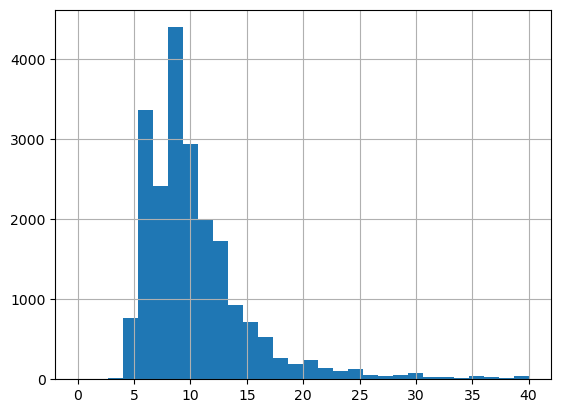

In [44]:
#print(df['kitchen_area'].value_counts())
df['kitchen_area'].hist(bins=30, range=(0,40)); # распределение площади кухни

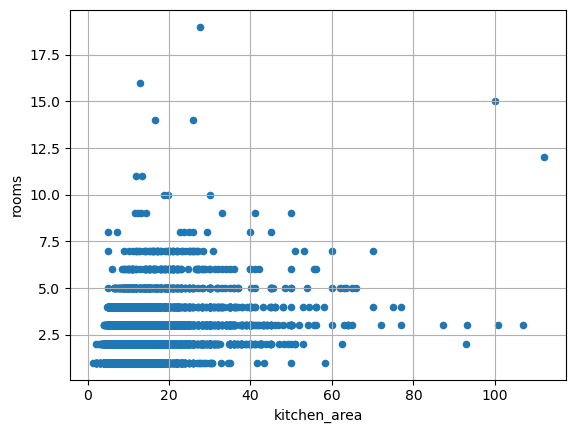

In [45]:
# зависимость площади кухни от количества комнат
df.plot(x='kitchen_area', y='rooms', kind='scatter', grid=True);

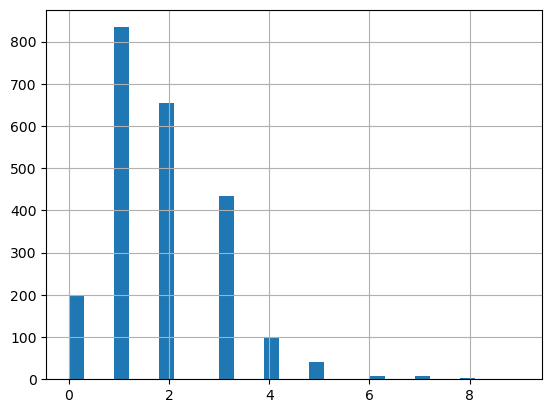

In [46]:
# распределение количества комнат среди квартир с пропущенным значением площади кухни
df[df['kitchen_area'].isna()]['rooms'].hist(bins=30);

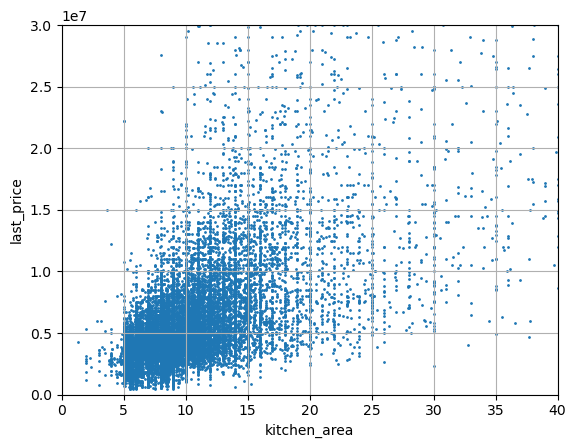

In [47]:
df.plot(x='kitchen_area', y='last_price', kind='scatter', 
        grid=True, xlim=[0,40], ylim=[0,30000000], s=1);

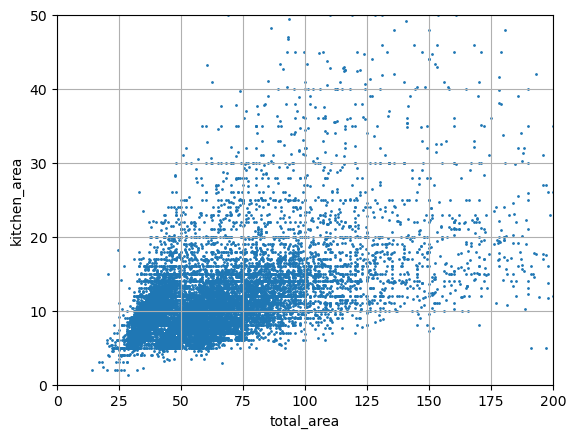

In [48]:
df.plot(x='total_area', y='kitchen_area', kind='scatter', 
        grid=True, xlim=[0,200], ylim=[0,50], s=1); # зависимость площади кухни от общей

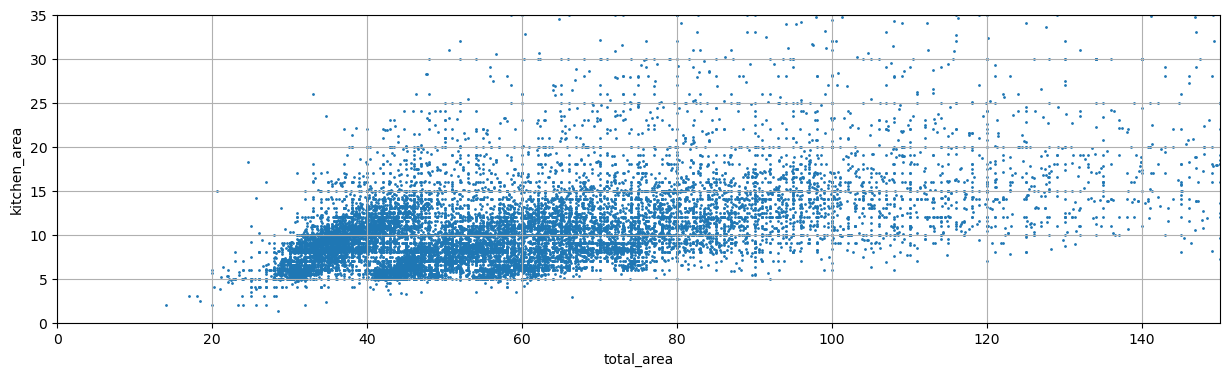

In [49]:
# зависимость площади кухни от общей
df.plot(x='total_area', y='kitchen_area', kind='scatter', 
        grid=True, xlim=[0,150], ylim=[0,35], s=1, figsize=(15,4));

In [50]:
df['kitchen_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

In [51]:
#df.corr()

In [52]:
print(len(df[df['total_area']>150]))
print(df[df['total_area']>150].apply(test_90, axis=1).sum())

564
21


In [53]:
print(len(df[df['total_area']<150]))
print(df[df['total_area']<150].apply(test_90, axis=1).sum())

23117
469


In [54]:
print(df[df['total_area']<50]['kitchen_area'].median())
print(df[df['total_area']<50]['kitchen_area'].mean())

8.0
8.52758300680553


In [55]:
print(len(df[df['total_area']>120]))
print(len(df[df['total_area']>150]))

1062
564


In [56]:
print(df[df['total_area']>120]['kitchen_area'].median())
print(df[df['total_area']>150]['kitchen_area'].median())

19.0
21.21


Заполним пропуски медианой с коэффициентом 0,85 для групп по общей площади: 0-25, 25-35, 35-45, 45-60, 60-80, 80-120, 120+ кв.м.

In [57]:
def kitchen_func(row):
    area = row['total_area']
    try:
        if area <= 25:
            return df[df['total_area'] <= 25]['kitchen_area'].median()*0.85
        elif area <= 35:
            return df[(df['total_area'] > 25)&(
                df['total_area'] <= 35)]['kitchen_area'].median()*0.85
        elif area <= 45:
            return df[(df['total_area'] > 35)&(
                df['total_area'] <= 45)]['kitchen_area'].median()*0.85
        elif area <=60:
            return df[(df['total_area'] > 45)&(
                df['total_area'] <= 60)]['kitchen_area'].median()*0.85
        elif area <=80:
            return df[(df['total_area'] > 60)&(
                df['total_area'] <= 80)]['kitchen_area'].median()*0.85
        elif area <=120:
            return df[(df['total_area'] > 80)&(
                df['total_area'] <= 120)]['kitchen_area'].median()*0.85
        elif area > 120:
            return df[df['total_area'] > 120]['kitchen_area'].median()*0.85
    except:
        return df['kitchen_area'].median()*0.85

In [58]:
#заполнение пропусков
for index, row in df[df['kitchen_area'].isna()].iterrows():
    df.loc[index, 'kitchen_area'] = kitchen_func(row)

In [59]:
print(df['kitchen_area'].isna().sum()) #проверка заполнения пропущенных значений

0


In [60]:
print(df.apply(test_90, axis=1).sum())
print(df.apply(test_100, axis=1).sum())

664
112


In [61]:
df['kitchen_area'].describe()

count    23699.000000
mean        10.285337
std          5.737919
min          1.300000
25%          7.000000
50%          9.000000
75%         11.500000
max        112.000000
Name: kitchen_area, dtype: float64

##### Удаление аномалий

In [62]:
df[df['total_area']*0.9 <= (df ['living_area']+ df ['kitchen_area'])]\
[['total_area','living_area','kitchen_area']]

,total_area,living_area,kitchen_area
41,74.0,59.00,12.00
171,49.0,38.00,10.00
184,30.2,26.10,6.20
220,37.0,28.00,9.00
237,28.1,20.75,5.95
...,...,...,...
23216,114.0,90.20,16.00
23297,48.2,42.20,6.00
23328,54.0,40.00,10.00
23521,65.0,44.00,15.30


Удалим аномалии:

In [63]:
print(len(df))
print(df.apply(test_90, axis=1).sum())
df = df[df['total_area']*0.9 >= (df['living_area'] + df['kitchen_area'])]
print(len(df))
print('Осталось от исходных данных (%):', round((len(df) / len(data) * 100), 2))

23699
664
23050
Осталось от исходных данных (%): 97.26


##### balcony (число балконов)

In [64]:
print('Количество пропусков: {}'.format(
    data['balcony'].isna().sum()))

Количество пропусков: 11519


Пропуски значения в столбце, содержащем количество балконов, учитывая большое количество таких пропусков, скорее всего означают отсутствие балкона. <br>
Заполним пропуски нулем.

In [65]:
df['balcony'] = df['balcony'].fillna(0)

C:\Users\Sergey\AppData\Local\Temp\ipykernel_10980\193950032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['balcony'] = df['balcony'].fillna(0)


In [66]:
print(df['balcony'].isna().sum()) #проверка заполнения пропущенных значений
df['balcony'].value_counts()

0


0.0    14839
1.0     4113
2.0     3547
5.0      297
4.0      176
3.0       78
Name: balcony, dtype: int64

##### locality_name (название населённого пункта)

In [67]:
print('Количество пропусков: {}'.format(
    data['locality_name'].isna().sum()))

Количество пропусков: 49


Заполнить названия населенных пунктов не представляется возможным. Удаляем.

In [68]:
df = df.dropna(subset=['locality_name'])

In [69]:
print(df['locality_name'].isna().sum()) #проверка заполнения пропущенных значений

0


##### Картографические данные

###### Расстояние до аэропорта и центра города

In [70]:
print('Количество пропусков airports_nearest: {}'.format(
    data['airports_nearest'].isna().sum()))
print('Количество пропусков cityCenters_nearest: {}'.format(
    data['cityCenters_nearest'].isna().sum()))

Количество пропусков airports_nearest: 5542
Количество пропусков cityCenters_nearest: 5519


Оставим пропуски незаполненными, т.к. узнать значения не представляется возможным, а медиана не подходит.

###### Число парков и водоемов в радиусе 3 км

In [71]:
print('Количество пропусков parks_around3000: {}'.format(
    data['parks_around3000'].isna().sum()))
print('Количество пропусков ponds_around3000: {}'.format(
    data['ponds_around3000'].isna().sum()))

Количество пропусков parks_around3000: 5518
Количество пропусков ponds_around3000: 5518


Отсутствие значений может означать отсутствие парков и водоемов в радиусе 3 км, либо ошибку при заполнении данных.

Заполним пропуски нулем (парки и водоемы в радиусе 3 км отсутствуют).

In [72]:
df['parks_around3000'] = df['parks_around3000'].fillna(0)

In [73]:
print(df['parks_around3000'].isna().sum()) #проверка заполнения пропущенных значений
df['parks_around3000'].value_counts()

0


0.0    15157
1.0     5552
2.0     1670
3.0      623
Name: parks_around3000, dtype: int64

In [74]:
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)

In [75]:
print(df['ponds_around3000'].isna().sum()) #проверка заполнения пропущенных значений
df['ponds_around3000'].value_counts()

0


0.0    14177
1.0     5548
2.0     1838
3.0     1439
Name: ponds_around3000, dtype: int64

###### Расстояние до ближайшего парка, пруда (м)

In [76]:
print('Количество пропусков parks_nearest: {}'.format(
    data['parks_nearest'].isna().sum()))
print('Количество пропусков ponds_nearest: {}'.format(
    data['ponds_nearest'].isna().sum()))

Количество пропусков parks_nearest: 15620
Количество пропусков ponds_nearest: 14589


In [77]:
print(df['parks_nearest'].max())

3190.0


In [78]:
print(df['ponds_nearest'].max())

1344.0


Скорее всего, расстояние до ближайшего парка и пруда рассчитывается при наличии таких объектов в радиусе 3 км.

Не заполняем пропуски.

##### days_exposition (время размещение объявления)

In [79]:
print('Количество пропусков: {}'.format(
    data['days_exposition'].isna().sum()))

Количество пропусков: 3181


In [80]:
print(df['days_exposition'].min())

1.0


Отсутствие значения времени размещения объявления может означать, что квартира была продана в течение одного дня (0 полных дней), квартира находится в процессе продажи (объявление не закрыто на момент создания выгрузки), либо данные просто не заполнены в результате ошибки.

Не заполняем пропуски.

In [81]:
print('Итоговая проверка заполнения пропусков:\n', df.isna().sum())

Итоговая проверка заполнения пропусков:
 total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5350
cityCenters_nearest      5327
parks_around3000            0
parks_nearest           15153
ponds_around3000            0
ponds_nearest           14177
days_exposition          3089
dtype: int64


#### Изменение типов данных

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23002 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23002 non-null  int64  
 1   last_price            23002 non-null  float64
 2   total_area            23002 non-null  float64
 3   first_day_exposition  23002 non-null  object 
 4   rooms                 23002 non-null  int64  
 5   ceiling_height        23002 non-null  float64
 6   floors_total          23002 non-null  float64
 7   living_area           23002 non-null  float64
 8   floor                 23002 non-null  int64  
 9   is_apartment          23002 non-null  bool   
 10  studio                23002 non-null  bool   
 11  open_plan             23002 non-null  bool   
 12  kitchen_area          23002 non-null  float64
 13  balcony               23002 non-null  float64
 14  locality_name         23002 non-null  object 
 15  airports_nearest   

In [83]:
df.sample()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
11199,14,14300000.0,69.5,2018-03-17T00:00:00,2,3.0,6.0,35.8,2,False,...,14.4,0.0,Санкт-Петербург,22947.0,2488.0,0.0,NaN,0.0,NaN,100.0


1. first_day_exposition: object to datetime. В данном столбце находится дата публикации объявления.

In [84]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], 
                                            format='%Y-%m-%dT%H:%M:%S')

2. floors_total: float to int. В данном столбце хранится значение этажности дома.

In [85]:
df['floors_total'].value_counts()

5.0     5650
9.0     3733
12.0    1353
16.0    1342
10.0    1154
4.0     1151
25.0    1032
6.0      869
17.0     825
3.0      638
7.0      570
14.0     537
18.0     485
24.0     441
8.0      376
2.0      353
15.0     352
23.0     335
19.0     326
22.0     278
20.0     265
13.0     227
11.0     193
27.0     160
21.0     145
26.0     137
1.0       23
35.0      22
28.0      21
36.0       3
34.0       1
60.0       1
29.0       1
33.0       1
52.0       1
37.0       1
Name: floors_total, dtype: int64

Количество этажей - это целые значения.

In [86]:
df['floors_total'] = df['floors_total'].astype('int')

3. balcony: float to int. В данном столбце записано количество балконов.

In [87]:
df['balcony'].value_counts()

0.0    14801
1.0     4105
2.0     3546
5.0      297
4.0      175
3.0       78
Name: balcony, dtype: int64

Количество балконов - это целые значения.

In [88]:
df['balcony'] = df['balcony'].astype('int')

4. parks_around3000, ponds_around3000: float to int. В данных столцах записано количество парков/водных объектов в радиусе 3 км.

In [89]:
df['parks_around3000'].value_counts()

0.0    15157
1.0     5552
2.0     1670
3.0      623
Name: parks_around3000, dtype: int64

In [90]:
df['ponds_around3000'].value_counts()

0.0    14177
1.0     5548
2.0     1838
3.0     1439
Name: ponds_around3000, dtype: int64

Количество парков/водных объектов - это целые значения.

In [91]:
df['parks_around3000'] = df['parks_around3000'].astype('int')

In [92]:
df['ponds_around3000'] = df['ponds_around3000'].astype('int')

5. days_exposition: float to int. В данном столбце записано количество дней, в течении которых было размещено объявление (от публикации до снятия).

In [93]:
df['days_exposition'].value_counts()
#df.sample(50)

45.0      856
60.0      528
7.0       219
30.0      202
90.0      197
         ... 
795.0       1
1089.0      1
849.0       1
992.0       1
971.0       1
Name: days_exposition, Length: 1138, dtype: int64

Количество дней - это целые значения. Но в значениях присутствуют пропуски значений, в связи с чем изменение типа данных столбца невозможно.

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23002 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23002 non-null  int64         
 1   last_price            23002 non-null  float64       
 2   total_area            23002 non-null  float64       
 3   first_day_exposition  23002 non-null  datetime64[ns]
 4   rooms                 23002 non-null  int64         
 5   ceiling_height        23002 non-null  float64       
 6   floors_total          23002 non-null  int32         
 7   living_area           23002 non-null  float64       
 8   floor                 23002 non-null  int64         
 9   is_apartment          23002 non-null  bool          
 10  studio                23002 non-null  bool          
 11  open_plan             23002 non-null  bool          
 12  kitchen_area          23002 non-null  float64       
 13  balcony         

#### Удаление дубликатов

In [95]:
df.duplicated().sum()

0

Явные дубликаты отсутсвуют.

In [96]:
print(len(df['locality_name'].unique()))
print(df['locality_name'].unique())

362
['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый

Неявные дубликаты:
- городской посёлок Янино-1, городской поселок Янино-1;
- Мурино, посёлок Мурино, поселок Мурино;
- Кудрово, деревня Кудрово;
- поселок городского типа Красный Бор, посёлок городского типа Красный Бор;
- посёлок городского типа Лебяжье, поселок городского типа Лебяжье;
- поселок городского типа Кузьмоловский, посёлок городского типа Кузьмоловский;
- посёлок Аннино, поселок Аннино;
- посёлок Новый Свет, поселок Новый Свет;
- посёлок Бугры, поселок Бугры;
- поселок городского типа Рощино, посёлок городского типа Рощино, городской посёлок Рощино;
- посёлок Победа, поселок Победа;
- поселок Терволово, посёлок Терволово;
- поселок городского типа Советский, городской посёлок Советский;
- посёлок Петровское, поселок Петровское;
- посёлок городского типа Токсово, поселок городского типа Токсово;
- посёлок городского типа Вырица, поселок городского типа Вырица;
- посёлок Тельмана, поселок Тельмана;
- городской поселок Большая Ижора, поселок городского типа Большая Ижора;
- городской посёлок Павлово, посёлок городского типа Павлово;
- городской посёлок Лесогорский, поселок городского типа Лесогорский;
- поселок городского типа имени Свердлова, посёлок городского типа имени Свердлова;
- посёлок Поляны, поселок Поляны;
- городской посёлок Мга, посёлок городского типа Мга и др.



Вывод: последовательно заменить посёлок - поселок, городской поселок - поселок городского типа, поселок Мурино - Мурино (Мурино теперь не поселок).

In [97]:
df['locality_name'] = df['locality_name'].str.replace(
    'посёлок', 'поселок')
df['locality_name'] = df['locality_name'].str.replace(
    'городской поселок', 'поселок городского типа')
df['locality_name'] = df['locality_name'].str.replace(
    'поселок Мурино', 'Мурино')

In [98]:
print(len(df['locality_name'].unique()))
print(df['locality_name'].unique())

320
['Санкт-Петербург' 'поселок Шушары' 'поселок городского типа Янино-1'
 'поселок Парголово' 'Мурино' 'Ломоносов' 'Сертолово' 'Петергоф' 'Пушкин'
 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'деревня Фёдоровское'
 'Выборг' 'Кронштадт' 'Кировск' 'деревня Новое Девяткино'
 'поселок Металлострой' 'поселок городского типа Лебяжье'
 'поселок городского типа Сиверский' 'поселок Молодцово'
 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'поселок Аннино' 'поселок городского типа Ефимовский'
 'поселок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'поселок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'поселок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Шлиссельбург' 'Никольское' 'Зеленогорск'
 'Сосновый Бор' 'деревня Оржицы' 'деревня Кальтино' 'Кудро

In [99]:
df.duplicated().sum()

0

В названиях населенных пунктов убрано 42 неявных дубликата. Явных дубликатов при этом не появилось.

#### Удаление аномалий

In [100]:
print('Осталось от исходных данных (%):', round((len(df) / len(data) * 100), 2))

Осталось от исходных данных (%): 97.06


##### balcony (количество балконов)

In [101]:
df['balcony'].value_counts()

0    14801
1     4105
2     3546
5      297
4      175
3       78
Name: balcony, dtype: int64

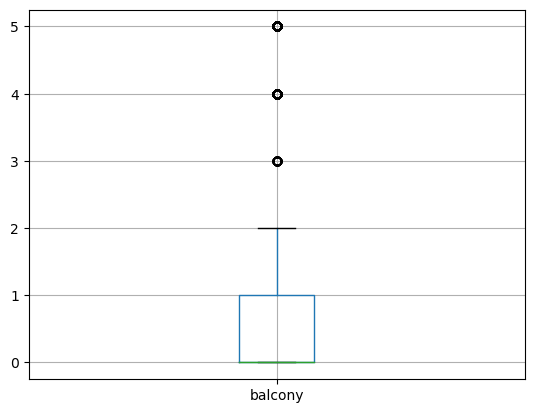

In [102]:
df.boxplot(column='balcony');

In [103]:
print(len(df[df['balcony'] <= 3]) / len(data))

0.9506730241782354


In [104]:
# оставим только квартиры не более чем с тремя балконами
df = df[df['balcony'] <= 3]

In [105]:
print('Осталось от исходных данных (%):', round((len(df) / len(data) * 100), 2))

Осталось от исходных данных (%): 95.07


##### ceiling_height (высота потолков)

In [106]:
df['ceiling_height'].describe()

count    22530.000000
mean         2.714059
std          0.687896
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         32.000000
Name: ceiling_height, dtype: float64

In [107]:
df['ceiling_height'].sort_values(ascending=False).head(10)

3148     32.0
20478    27.0
4876     27.0
22938    27.0
17857    27.0
5246     27.0
10773    27.0
5669     26.0
4643     25.0
9379     25.0
Name: ceiling_height, dtype: float64

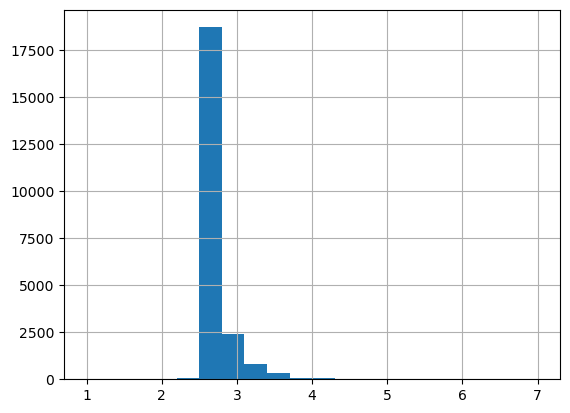

In [108]:
df['ceiling_height'].hist(bins=20, range=(1,7));

Гипотеза: высота потолков более 20 м вызвана ошибкой заполнения, например: 2,0 - 20.
Произведём замену:

In [109]:
df.loc[df['ceiling_height']>=20, 'ceiling_height'] = \
df.loc[df['ceiling_height']>=20, 'ceiling_height'] / 10

In [110]:
df['ceiling_height'].describe()

count    22530.000000
mean         2.696418
std          0.248452
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         14.000000
Name: ceiling_height, dtype: float64

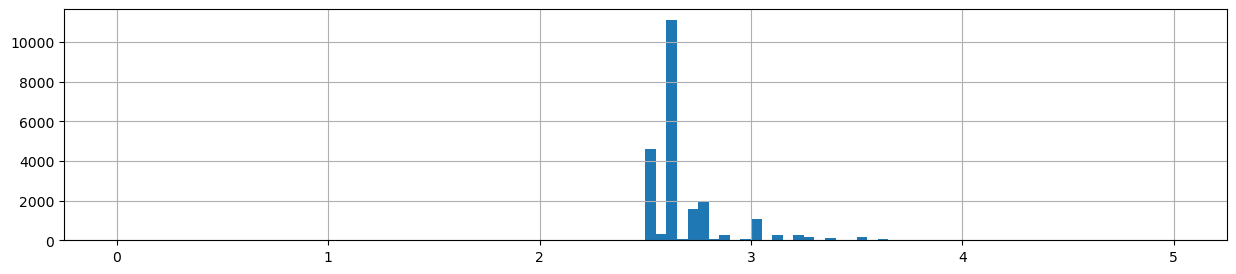

In [111]:
df['ceiling_height'].hist(bins=100, range=(0,5), figsize=(15,3));

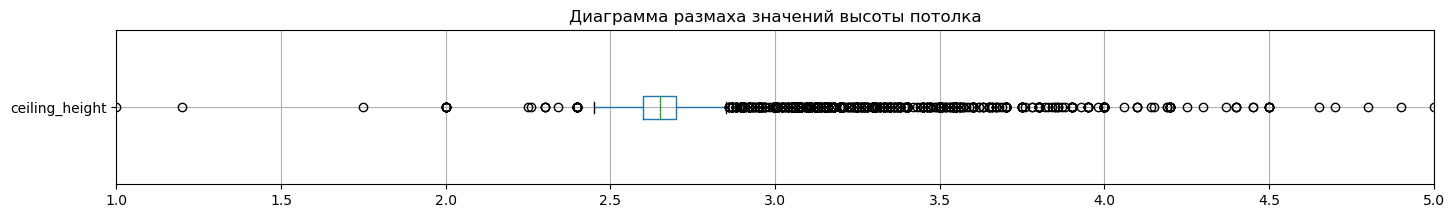

In [112]:
fig, ax = plt.subplots(figsize = (17,2))
ax = df[['ceiling_height']].boxplot(vert = False, ax=ax)
ax.set_title('Диаграмма размаха значений высоты потолка')
ax.set_xlim(1, 5);

Удалим строки с высотой потолков меньше 2,45 и больше 4:

In [113]:
df = df[(df['ceiling_height'] >= 2.45) & (df['ceiling_height'] <= 4)]

In [114]:
print('Осталось от исходных данных (%):', round((len(df) / len(data) * 100), 2))

Осталось от исходных данных (%): 94.7


##### floors_total (этажность дома)

In [115]:
df['floors_total'].describe()

count    22442.000000
mean        10.644729
std          6.564663
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

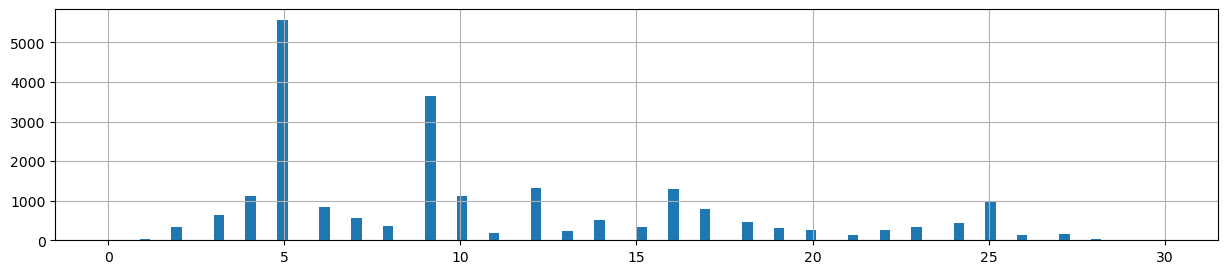

In [116]:
df['floors_total'].hist(bins=100, range=(0,30), figsize=(15,3));

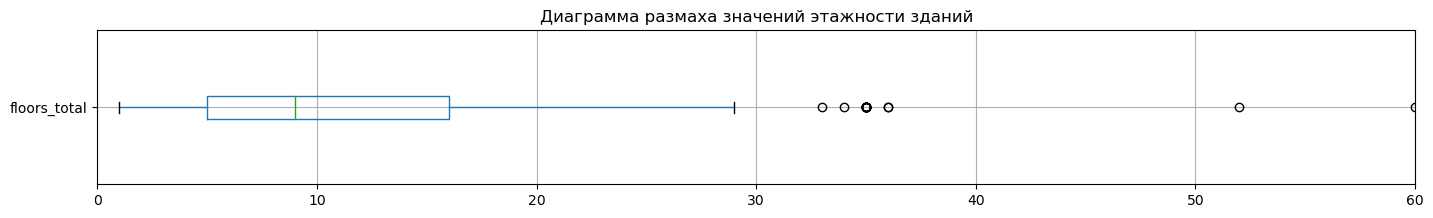

In [117]:
fig, ax = plt.subplots(figsize = (17,2))
ax = df[['floors_total']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений этажности зданий')
ax.set_xlim(0, 60);

In [118]:
len(df[df['floors_total']<2])

22

Удалим строки со зданиями выше 30 этажей и ниже 2:

In [119]:
df = df[(df['floors_total']<=30)&(df['floors_total']>=2)]
print(df.shape[0])

22392


In [120]:
df['floors_total'].max()

29

In [121]:
print('Осталось от исходных данных (%):', round((len(df) / len(data) * 100), 2))

Осталось от исходных данных (%): 94.48


##### floor (этаж)

In [122]:
df['floor'].describe()

count    22392.000000
mean         5.847535
std          4.818401
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64

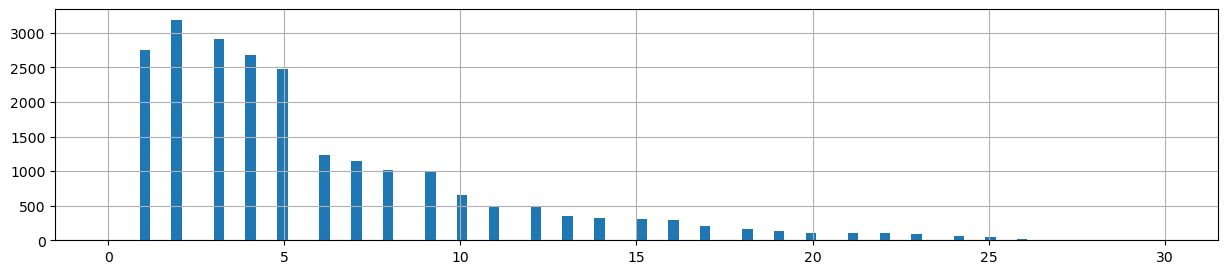

In [123]:
df['floor'].hist(bins=100, range=(0,30), figsize=(15,3));

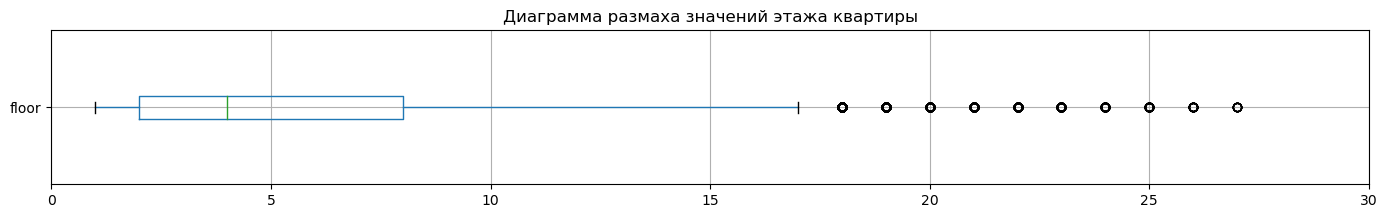

In [124]:
fig, ax = plt.subplots(figsize = (17,2))
ax = df[['floor']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений этажа квартиры')
ax.set_xlim(0, 30);

In [125]:
len(df[df['floor']>17])

834

Фильтрация по этажности домов проведена. Оставляем.

##### rooms (количество комнат)

In [126]:
df['rooms'].describe()

count    22392.000000
mean         2.058860
std          1.070312
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

In [127]:
df['rooms'].value_counts()

1     7752
2     7581
3     5364
4     1090
5      297
0      129
6       94
7       55
8       11
9        8
10       3
11       2
14       2
15       1
19       1
16       1
12       1
Name: rooms, dtype: int64

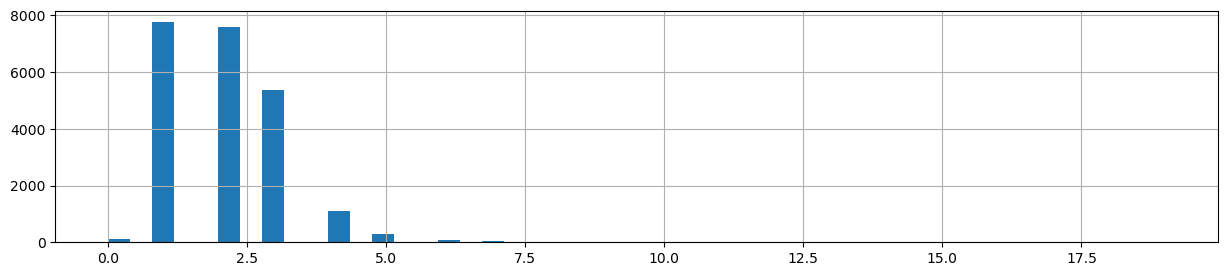

In [128]:
df['rooms'].hist(bins=48, figsize=(15,3));

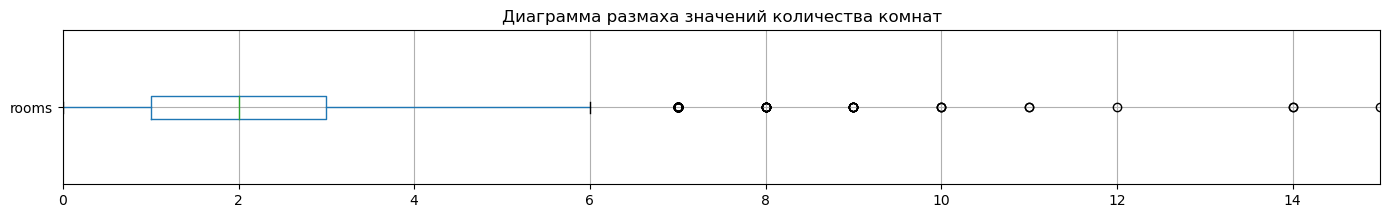

In [129]:
fig, ax = plt.subplots(figsize = (17,2))
ax = df[['rooms']].boxplot(vert = False, ax=ax)
ax.set_title('Диаграмма размаха значений количества комнат')
ax.set_xlim(0, 15);

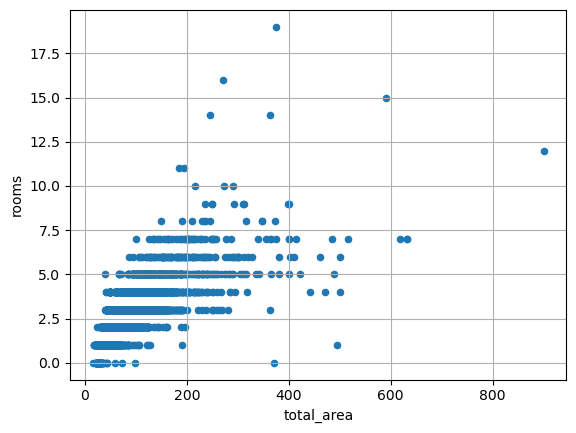

In [130]:
df.plot(x='total_area', y='rooms', kind='scatter', grid=True);

In [131]:
df[df['rooms']==0].sample(3) #посмотрим, есть ли что-то необычное в квартирах без комнат

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
11051,2,2200000.0,26.0,2017-10-24,0,2.65,21,12.0,21,False,...,5.9500,2,деревня Кудрово,NaN,NaN,0,NaN,0,NaN,35.0
6408,0,2450000.0,27.0,2017-11-07,0,2.65,23,14.0,22,False,...,5.9500,0,Мурино,NaN,NaN,0,NaN,0,NaN,66.0
4876,7,3000000.0,25.0,2017-09-27,0,2.70,25,17.0,17,False,...,3.6125,2,Мурино,NaN,NaN,0,NaN,0,NaN,28.0


Ноль комнат заменим на одну, поскольку в данных группах наиболее похожие цены.

In [132]:
df['rooms'] = df['rooms'].replace(0,1)

In [133]:
#оставшийся процент данных
print(int(df[df['rooms']<6]['rooms'].count() / df['rooms'].count() * 100), '%') 

99 %


Удалим строки с квартирами, имеющими 6 и более комнат:

In [134]:
df = df[df['rooms']<6]
print(df.shape[0])

22213


In [135]:
print('Осталось от исходных данных (%):', round((len(df) / len(data) * 100), 2))

Осталось от исходных данных (%): 93.73


##### total_area (общая площадь)

In [136]:
df['total_area'].describe()

count    22213.000000
mean        58.358690
std         29.197021
min         15.500000
25%         40.000000
50%         51.000000
75%         68.000000
max        500.000000
Name: total_area, dtype: float64

In [137]:
df['total_area'].sort_values(ascending=False)

15016    500.00
9826     494.10
6621     488.00
6221     470.30
3676     441.98
          ...  
8729      18.40
19311     18.00
6084      18.00
4542      18.00
8886      15.50
Name: total_area, Length: 22213, dtype: float64

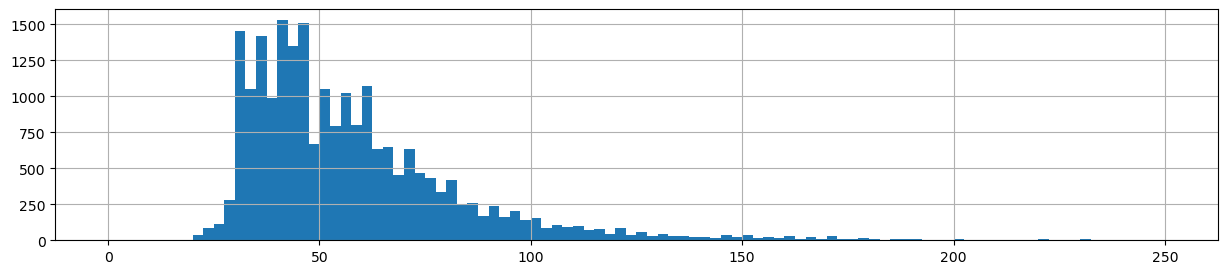

In [138]:
df['total_area'].hist(bins=100, figsize=(15,3), range=(0,250));

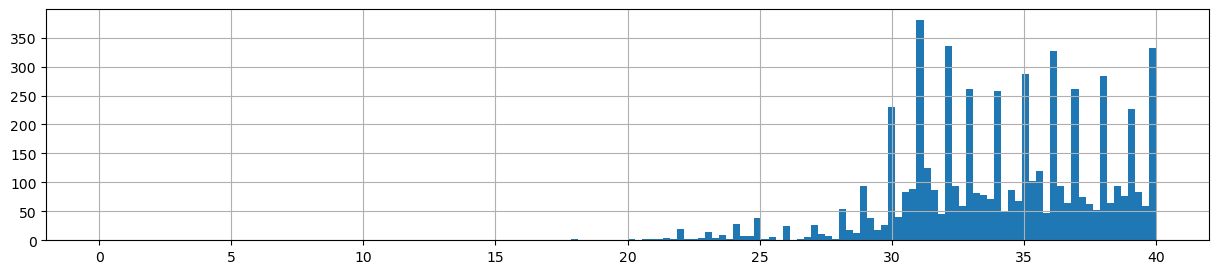

In [139]:
df['total_area'].hist(bins=150, figsize=(15,3), range=(0,40));

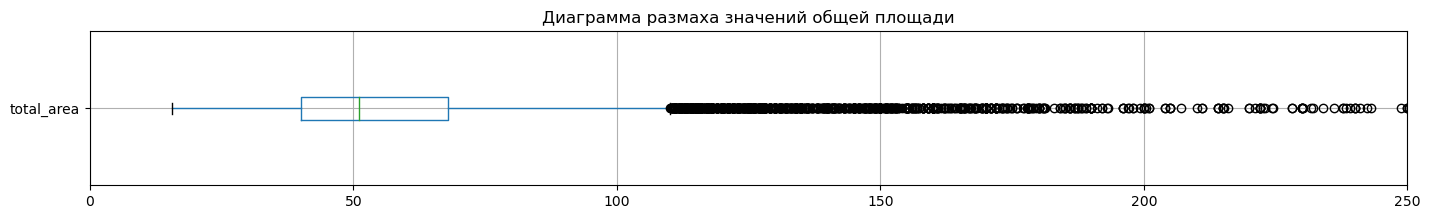

In [140]:
fig, ax = plt.subplots(figsize = (17,2))
ax = df[['total_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений общей площади')
ax.set_xlim(0, 250);

In [141]:
print(int(df[df['total_area']<=200]['total_area'].count() / 
          df['total_area'].count() * 100), '%')

99 %


Удалим строки с квартирами, площадь которых больше 200 кв.м и меньше 24 кв.м:

In [142]:
df = df[(df['total_area']<=200)&(df['total_area']>=24)]
print(len(df['last_price']))

22034


In [143]:
print('Осталось от исходных данных (%):', round((len(df) / len(data) * 100), 2))

Осталось от исходных данных (%): 92.97


##### living_area (жилая площадь)

In [144]:
df['living_area'].describe()

count    22034.000000
mean        32.322552
std         16.355186
min          2.000000
25%         18.080000
50%         29.700000
75%         41.000000
max        147.000000
Name: living_area, dtype: float64

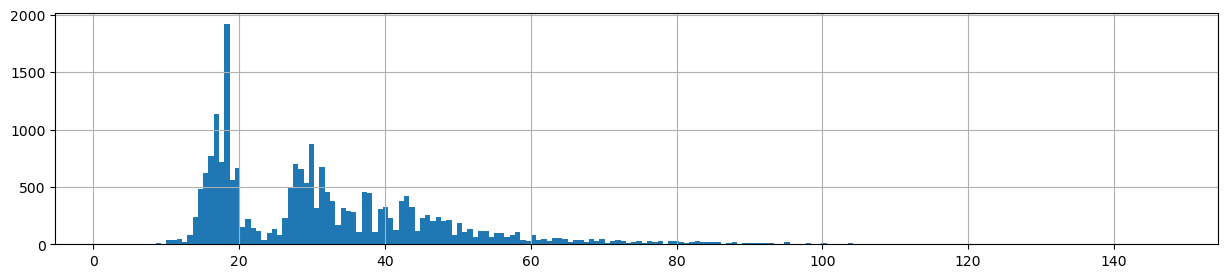

In [145]:
df['living_area'].hist(bins=200, figsize=(15,3));

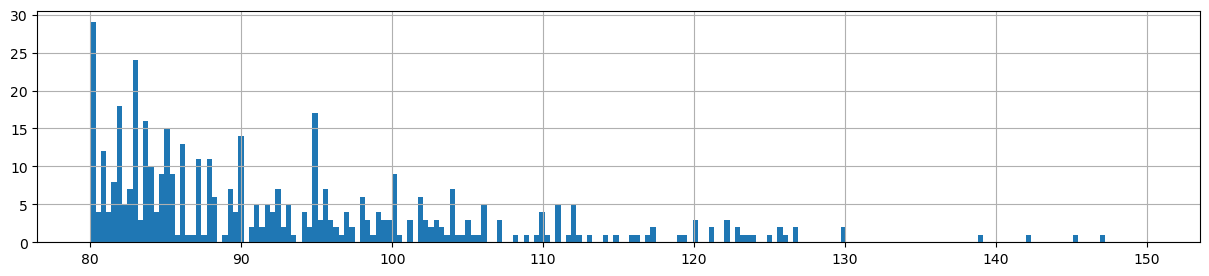

In [146]:
df['living_area'].hist(bins=200, range=(80,150), figsize=(15,3));

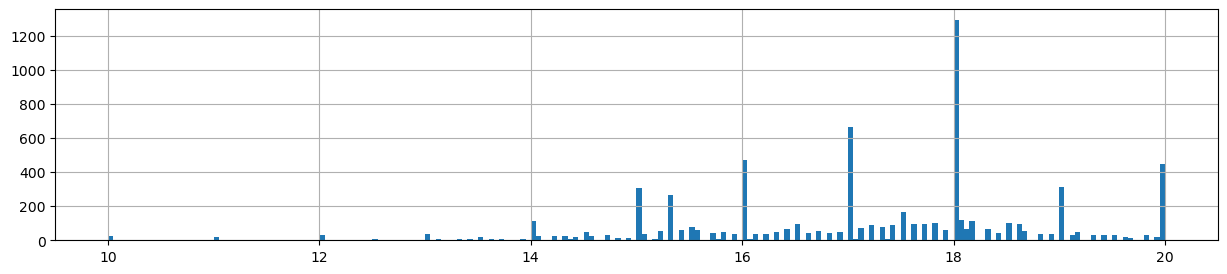

In [147]:
df['living_area'].hist(bins=200, range=(10,20), figsize=(15,3));

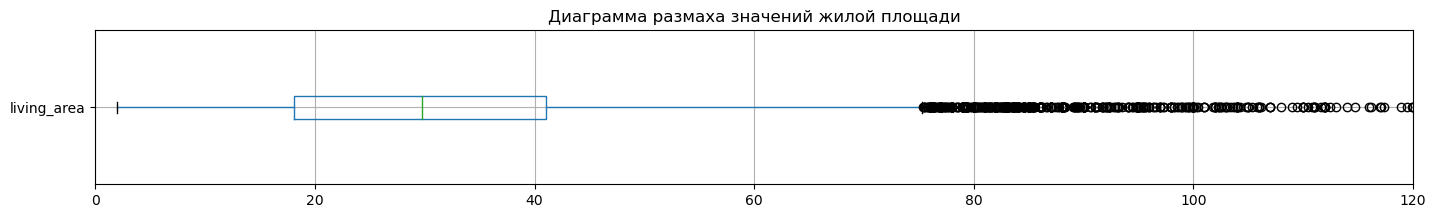

In [148]:
fig, ax = plt.subplots(figsize = (17,2))
ax = df[['living_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений жилой площади')
ax.set_xlim(0, 120);

In [149]:
len(df[(df['living_area']<=130)&(df['living_area']>=13.5)])

21798

Удалим строки с жилой площадью более 130 кв.м и менее 13,5 кв.м:

In [150]:
df = df[(df['living_area']<=130)&(df['living_area']>=13.5)]

In [151]:
print('Осталось от исходных данных (%):', round((len(df) / len(data) * 100), 2))

Осталось от исходных данных (%): 91.98


##### kitchen_area (площадь кухни)

In [152]:
df['kitchen_area'].describe()

count    21798.000000
mean         9.947022
std          4.867402
min          1.300000
25%          7.000000
50%          9.000000
75%         11.200000
max         93.200000
Name: kitchen_area, dtype: float64

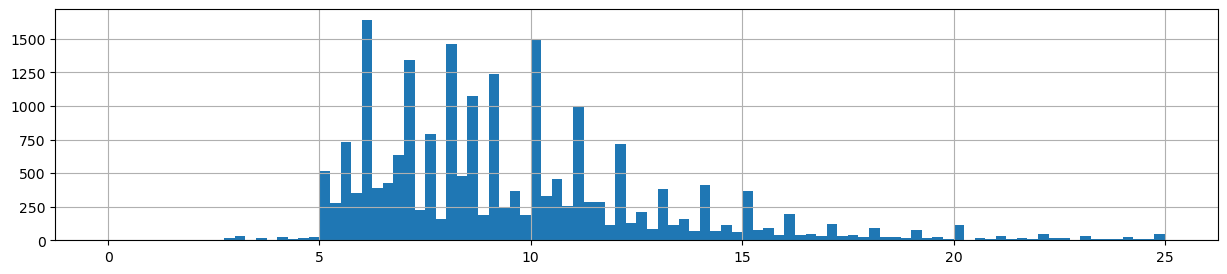

In [153]:
df['kitchen_area'].hist(bins=100, range=(0,25), figsize=(15,3));

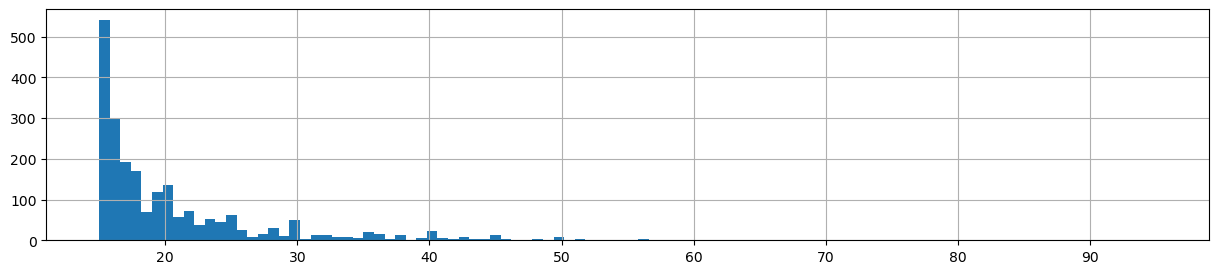

In [154]:
df['kitchen_area'].hist(bins=100, range=(15,95), figsize=(15,3));

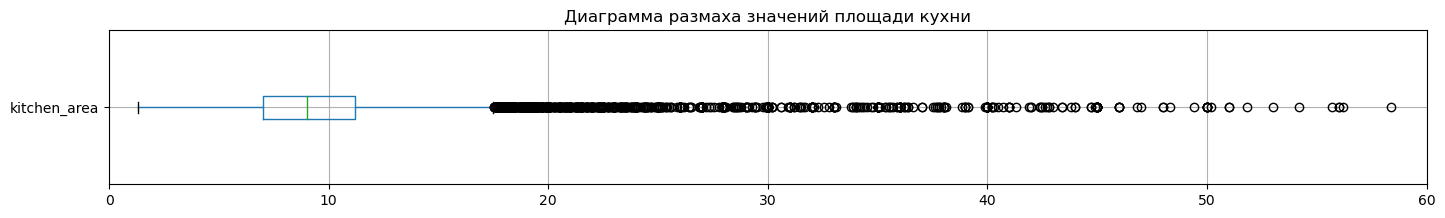

In [155]:
fig, ax = plt.subplots(figsize = (17,2))
ax = df[['kitchen_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади кухни')
ax.set_xlim(0, 60);

In [156]:
print(int(df[(df['kitchen_area'] >= 5) & (df['kitchen_area'] <= 50)]['kitchen_area']
          .count() / df['kitchen_area'].count() * 100), '%')
len(df[(df['kitchen_area'] >= 5) & (df['kitchen_area'] <= 50)])

99 %


21632

Удалим строки с площадью кухни менее 5 м и более 50 кв.м:

In [157]:
df = df[(df['kitchen_area'] >= 5) & (df['kitchen_area'] <= 50)]
print(df.shape[0])

21632


In [158]:
print('Осталось от исходных данных (%):', round((len(df) / len(data) * 100), 2))

Осталось от исходных данных (%): 91.28


##### last_price (цена)

In [159]:
df['last_price'].describe()

count    2.163200e+04
mean     5.919800e+06
std      5.942722e+06
min      1.219000e+04
25%      3.450000e+06
50%      4.600000e+06
75%      6.600000e+06
max      3.300000e+08
Name: last_price, dtype: float64

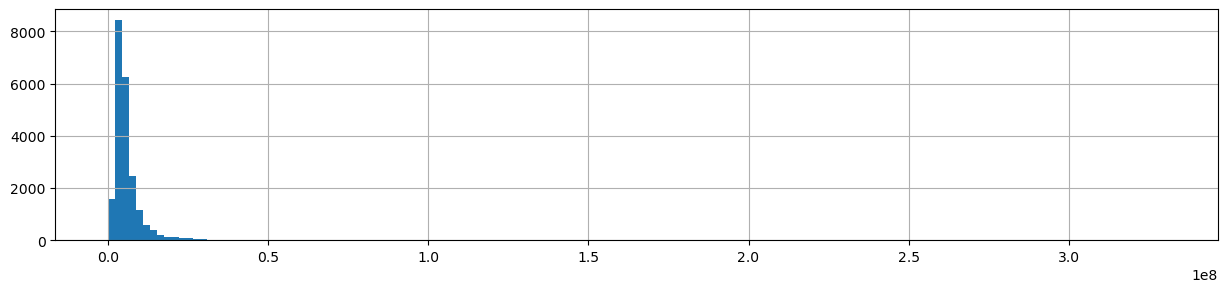

In [160]:
df['last_price'].hist(bins=150, figsize=(15,3));

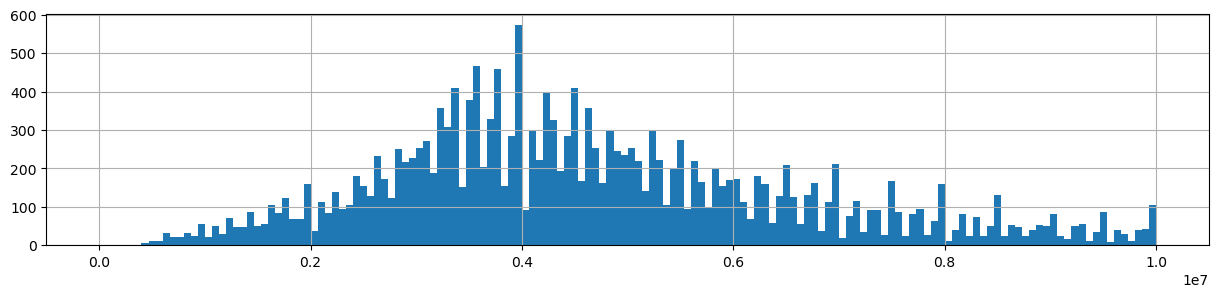

In [161]:
df['last_price'].hist(bins=150, figsize=(15,3), range=(0, 10000000));

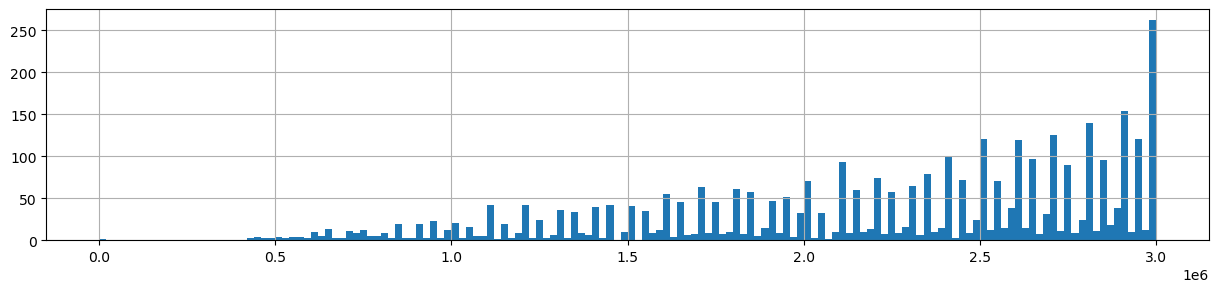

In [162]:
df['last_price'].hist(bins=150, figsize=(15,3), range=(0, 3000000));

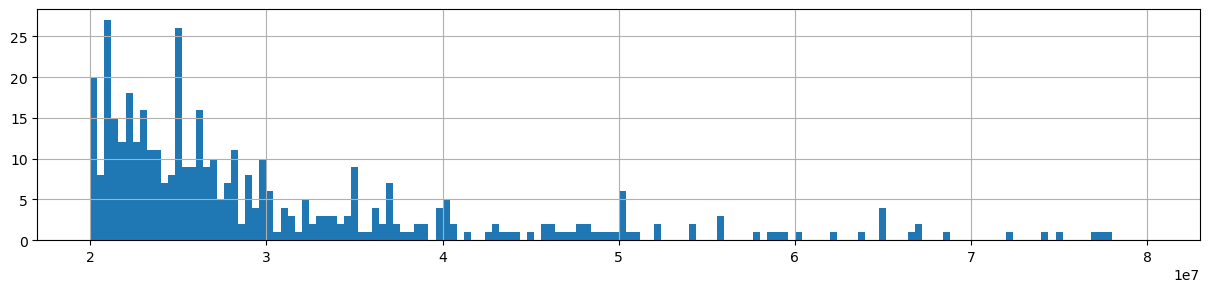

In [163]:
df['last_price'].hist(bins=150, figsize=(15,3), range=(20000000, 80000000));

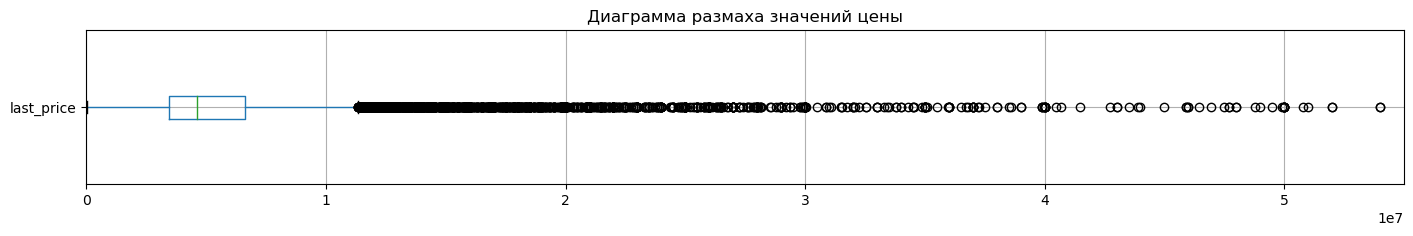

In [164]:
fig, ax = plt.subplots(figsize = (17,2))
ax = df[['last_price']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений цены')
ax.set_xlim(0, 55000000);

In [165]:
df['last_price'].sort_values(ascending=False)

1436     330000000.0
22831    289238400.0
4996     124000000.0
16590     98000000.0
11329     95000000.0
            ...     
17676       450000.0
16274       440000.0
17456       430000.0
14911       430000.0
8793         12190.0
Name: last_price, Length: 21632, dtype: float64

In [166]:
len(df[(df['last_price'] <= 55000000)&(df['last_price'] >= 1000000)])

21402

Удалим строки с квартирами, стоимость которых превышает 55 млн и меньше 1 млн:

In [167]:
df = df[(df['last_price'] <= 55000000)&(df['last_price'] >= 1000000)]

In [168]:
print('Осталось от исходных данных (%):', round((len(df) / len(data) * 100), 2))

Осталось от исходных данных (%): 90.31


##### days_exposition (время размещения объявления)

In [169]:
df['days_exposition'].describe()

count    18601.000000
mean       180.464437
std        219.712538
min          1.000000
25%         45.000000
50%         95.000000
75%        230.000000
max       1580.000000
Name: days_exposition, dtype: float64

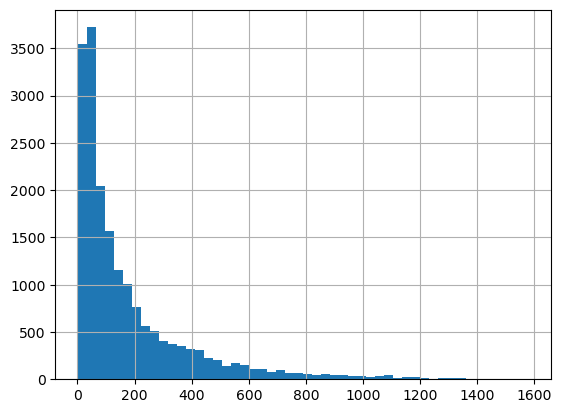

In [170]:
df['days_exposition'].hist(bins=50);

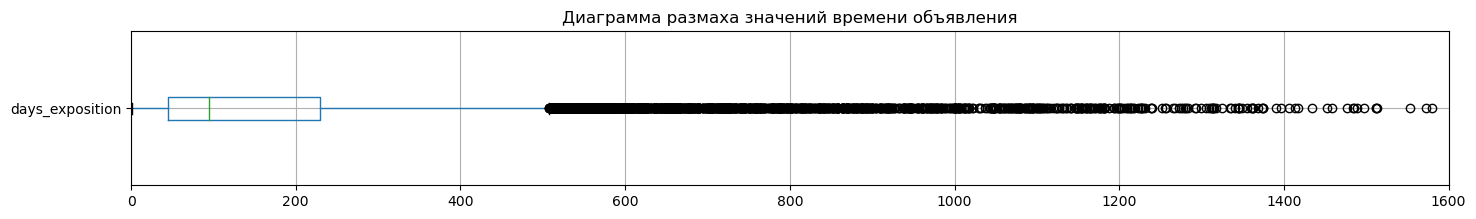

In [171]:
fig, ax = plt.subplots(figsize = (17,2))
ax = df[['days_exposition']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений времени объявления')
ax.set_xlim(0, 1600);

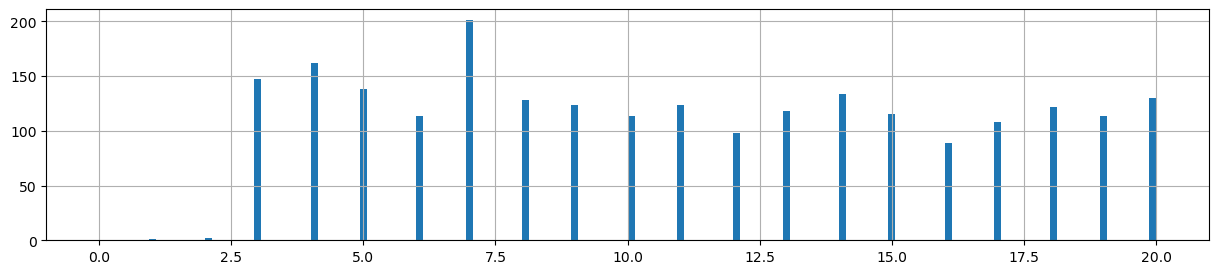

In [172]:
df['days_exposition'].hist(bins=150, figsize=(15,3), range=(0, 20));

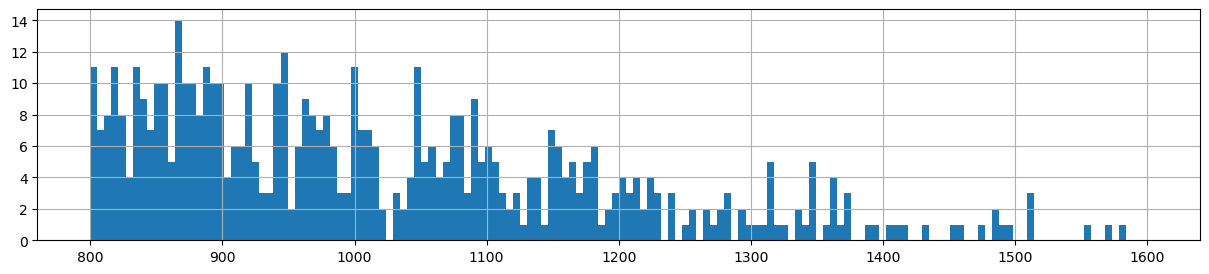

In [173]:
df['days_exposition'].hist(bins=150, figsize=(15,3), range=(800, 1600));

Очень большое время продажи свидетельствует о несбалансированности цены объекта и его характеристик. <br>
То же можно сказать и о маленьком времени продажи.

In [174]:
len(df[(df['days_exposition'].isna())|
       ((df['days_exposition'] <= 1400)&
        (df['days_exposition'] >= 3))])

21382

In [175]:
df = df[(df['days_exposition'].isna())|
        ((df['days_exposition'] <= 1400)&
         (df['days_exposition'] >= 3))]
print(df.shape[0])

21382


Удалим строки со временем размещения объявления более 1400 дней и менее 3 дней:

In [176]:
print('Осталось от исходных данных (%):', round((len(df) / len(data) * 100), 2))

Осталось от исходных данных (%): 90.22


In [177]:
df = df.reset_index()

In [178]:
df.describe()

,index,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,21382.000000,21382.000000,2.138200e+04,21382.000000,21382.000000,21382.000000,21382.000000,21382.000000,21382.000000,21382.000000,21382.000000,16543.000000,16563.000000,21382.000000,7262.000000,21382.000000,8163.000000,18581.000000
mean,11826.546581,9.842578,5.839948e+06,57.834869,2.032083,2.687218,10.703910,32.573769,5.870545,9.953915,0.513282,28873.942755,14361.327718,0.461323,493.222941,0.580675,523.771775,179.299284
std,6844.828963,5.649574,4.488531e+06,24.932447,0.941833,0.194705,6.481688,16.129711,4.814027,4.596075,0.768143,12701.432667,8556.637879,0.736810,343.552898,0.872283,276.860908,216.236694
min,0.000000,0.000000,1.000000e+06,24.000000,1.000000,2.450000,2.000000,13.500000,1.000000,5.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,3.000000
25%,5896.250000,6.000000,3.499000e+06,40.300000,1.000000,2.600000,5.000000,18.200000,2.000000,7.000000,0.000000,18446.000000,9624.000000,0.000000,289.000000,0.000000,303.000000,45.000000
50%,11809.500000,9.000000,4.600000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26933.000000,13219.000000,0.000000,456.000000,0.000000,507.000000,95.000000
75%,17750.750000,14.000000,6.600000e+06,68.000000,3.000000,2.700000,16.000000,41.000000,8.000000,11.220000,1.000000,37412.000000,16333.000000,1.000000,614.000000,1.000000,733.000000,230.000000
max,23697.000000,50.000000,5.400000e+07,200.000000,5.000000,4.000000,29.000000,130.000000,27.000000,50.000000,3.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1396.000000


---

От исходных данных осталось 90,22%. Потеря данных составила 9,78%, что в пределах допустимого.

---

In [179]:
# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# итоговые данные
(
    df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 
        'last_price', 'living_area',  'kitchen_area', 'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"21,382.00","21,382.00","21,382.00","18,581.00","21,382.00","21,382.00","21,382.00","21,382.00","21,382.00"
min,1.00,24.00,2.45,3.00,"1,000,000.00",13.50,5.00,1.00,2.00
max,5.00,200.00,4.00,"1,396.00","54,000,000.00",130.00,50.00,27.00,29.00


In [180]:
# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 
          'last_price', 'living_area',  'kitchen_area', 'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,699.00","23,699.00","14,504.00","20,518.00","23,699.00","21,796.00","21,421.00","23,699.00","23,613.00"
min,0.00,12.00,1.00,1.00,"12,190.00",2.00,1.30,1.00,1.00
max,19.00,900.00,100.00,"1,580.00","763,000,000.00",409.70,112.00,33.00,60.00


In [181]:
# Значения параметров объектов недвижимости на разных квантилях
# итоговые данные
(
    df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 
          'last_price', 'living_area',  'kitchen_area', 'floor', 'floors_total']]
    .quantile([0.01, .5, .90, .9976])  
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.010000,1.00,29.00,2.50,4.00,"1,300,000.00",14.30,5.00,1.00,2.00
0.500000,2.00,52.00,2.65,95.00,"4,600,000.00",30.00,9.00,4.00,9.00
0.900000,3.00,89.59,3.00,453.00,"10,000,000.00",52.00,14.90,13.00,22.00
0.997600,5.00,178.00,3.80,"1,234.26","37,841,428.80",106.14,40.20,25.00,27.00


In [182]:
# Значения параметров объектов недвижимости на разных квантилях
# сырые данные
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 
          'last_price', 'living_area',  'kitchen_area', 'floor', 'floors_total']]
    .quantile([0.01, .5, .90, .9976])  
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.010000,1.00,25.20,2.50,4.00,"1,000,000.00",13.00,5.00,1.00,2.00
0.500000,2.00,52.00,2.65,95.00,"4,650,000.00",30.00,9.10,4.00,9.00
0.900000,3.00,93.52,3.06,460.00,"10,914,231.20",55.00,15.90,13.00,22.00
0.997600,7.00,309.74,5.22,"1,311.28","82,000,000.00",181.25,50.00,25.00,27.00


### Посчитайте и добавьте в таблицу новые столбцы

#### Цена одного квадратного метра

In [183]:
df['kvm_cost'] = round((df['last_price'] / df['total_area']), 2)

In [184]:
df.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kvm_cost
0,0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,...,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.37
1,1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,...,2,поселок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.79
2,2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,...,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.71
3,4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,...,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.00
4,5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,...,0,поселок городского типа Янино-1,NaN,NaN,0,NaN,0,NaN,55.0,95065.79


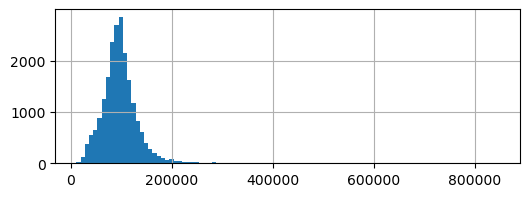

In [185]:
df['kvm_cost'].hist(bins=100, figsize=(6,2));

#### День недели публикации объявления 

In [186]:
df['day'] = df['first_day_exposition'].dt.weekday

In [187]:
df.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kvm_cost,day
0,0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,...,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.37,3
1,1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,...,поселок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.79,1
2,2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,...,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.71,3
3,4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,...,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.00,1
4,5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,...,поселок городского типа Янино-1,NaN,NaN,0,NaN,0,NaN,55.0,95065.79,0


#### Месяц публикации объявления

In [188]:
df['month'] = df['first_day_exposition'].dt.month

In [189]:
df.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kvm_cost,day,month
0,0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,...,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.37,3,3
1,1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,...,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.79,1,12
2,2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,...,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.71,3,8
3,4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,...,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.00,1,6
4,5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,...,NaN,NaN,0,NaN,0,NaN,55.0,95065.79,0,9


#### Год публикации объявления

In [190]:
df['year'] = df['first_day_exposition'].dt.year

In [191]:
df.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kvm_cost,day,month,year
0,0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,...,16028.0,1,482.0,2,755.0,NaN,120370.37,3,3,2019
1,1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,...,18603.0,0,NaN,0,NaN,81.0,82920.79,1,12,2018
2,2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,...,13933.0,1,90.0,2,574.0,558.0,92785.71,3,8,2015
3,4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,...,8098.0,2,112.0,1,48.0,121.0,100000.00,1,6,2018
4,5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,...,NaN,0,NaN,0,NaN,55.0,95065.79,0,9,2018


#### Тип этажа квартиры («первый», «последний», «другой»)

In [192]:
#функция возвращает тип этажа
def floor_type(row):
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == row['floors_total']:
        return 'последний'
    else: 
        return 'другой'

In [193]:
df['floor_type'] = df.apply(floor_type, axis=1)

In [194]:
df.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kvm_cost,day,month,year,floor_type
0,0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,...,1,482.0,2,755.0,NaN,120370.37,3,3,2019,другой
1,1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,...,0,NaN,0,NaN,81.0,82920.79,1,12,2018,первый
2,2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,...,1,90.0,2,574.0,558.0,92785.71,3,8,2015,другой
3,4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,...,2,112.0,1,48.0,121.0,100000.00,1,6,2018,другой
4,5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,...,0,NaN,0,NaN,55.0,95065.79,0,9,2018,другой


#### Расстояние до центра города, км

In [195]:
def center_city_km(metres):
    x = round((metres / 1000), 0)
    return x

In [196]:
df['center_city_km'] = df['cityCenters_nearest'].apply(center_city_km)

In [197]:
df.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kvm_cost,day,month,year,floor_type,center_city_km
0,0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,...,482.0,2,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,...,NaN,0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,...,90.0,2,574.0,558.0,92785.71,3,8,2015,другой,14.0
3,4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,...,112.0,1,48.0,121.0,100000.00,1,6,2018,другой,8.0
4,5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,...,NaN,0,NaN,55.0,95065.79,0,9,2018,другой,NaN


### Проведите исследовательский анализ данных

#### Изучение основных параметров

- общая площадь

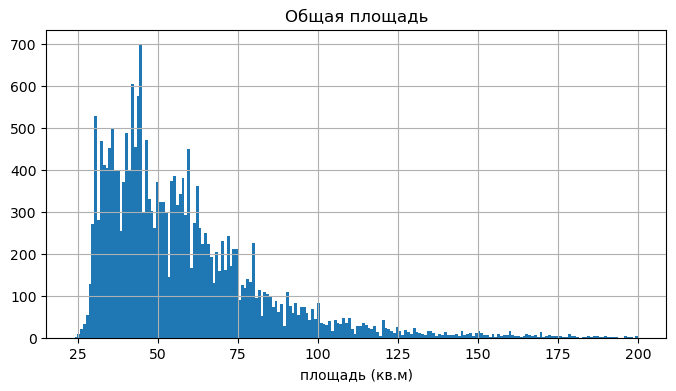

In [198]:
df['total_area'].hist(bins=200, figsize=(8,4));
plt.title('Общая площадь')
plt.xlabel('площадь (кв.м)')
plt.show()

In [199]:
df['total_area'].describe()

count    21382.000000
mean        57.834869
std         24.932447
min         24.000000
25%         40.300000
50%         52.000000
75%         68.000000
max        200.000000
Name: total_area, dtype: float64

Большинство квартир имеют площадь от 35 до 65 кв.м и примерно делятся на три группы: 35 кв.м, 45 кв.м, 55 кв.м.

- жилая площадь

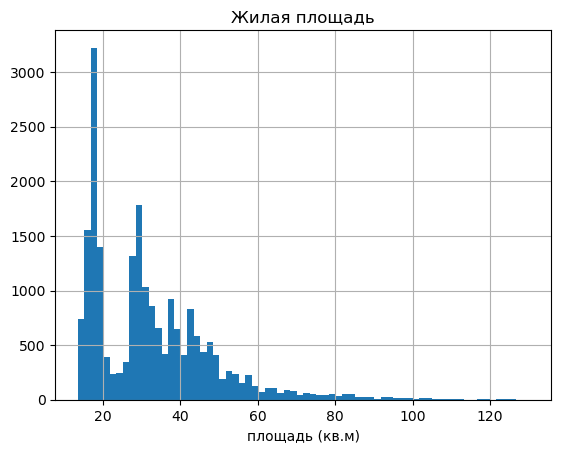

In [200]:
df['living_area'].hist(bins=70)
plt.title('Жилая площадь')
plt.xlabel('площадь (кв.м)')
plt.show()

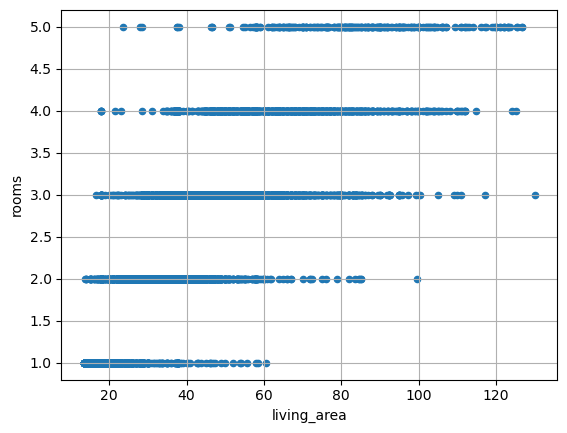

In [201]:
df.plot(x='living_area', y='rooms', kind='scatter', grid=True);

In [202]:
print(df['living_area'].corr(df['rooms']))

0.8680302798306235


Выделяются три группы значений жилой площади: 18 м, 30 м, 45 м. <br>
Указанные группы связаны с количеством комнат. Чем больше комнат, тем больше жилая площадь квартиры.

- площадь кухни

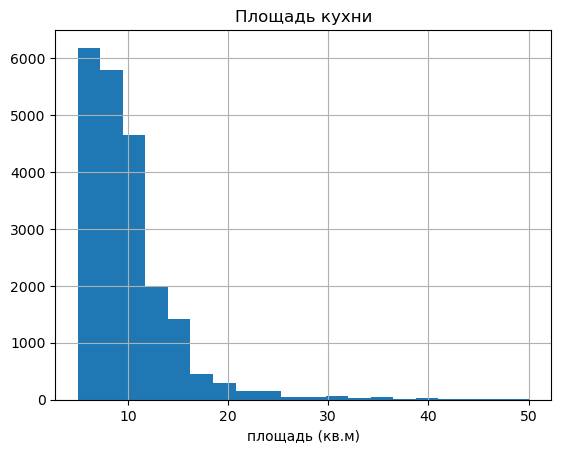

Медиана: 9.0
Среднее: 9.95


In [203]:
df['kitchen_area'].hist(bins=20)
plt.title('Площадь кухни')
plt.xlabel('площадь (кв.м)')
plt.show()

print('Медиана:', df['kitchen_area'].median())
print('Среднее:', round(df['kitchen_area'].mean(), 2))

Большинство кухонь имеют площадь около 9,5 кв.м.

- цена

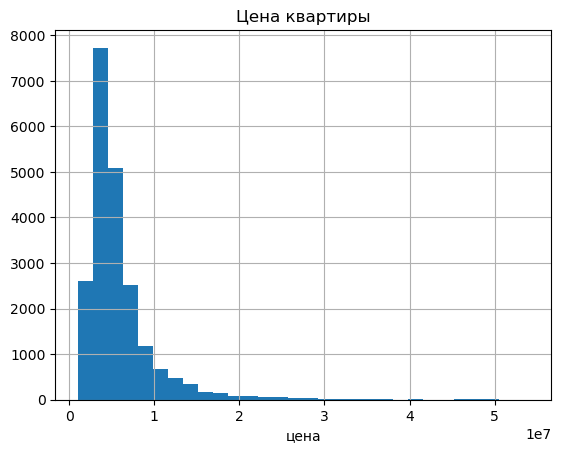

In [204]:
df['last_price'].hist(bins=30)
plt.title('Цена квартиры')
plt.xlabel('цена')
plt.show()

In [205]:
df['last_price'].median()

4600000.0

Средняя (медианная) цена квартиры составляет 4,6 млн.

- количество комнат

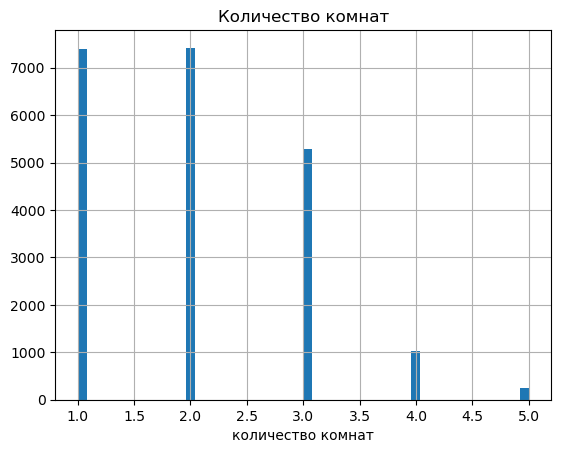

In [206]:
df['rooms'].hist(bins=50)
plt.title('Количество комнат')
plt.xlabel('количество комнат')
plt.show()

Чем меньше комнат - тем больше предложение на рынке жилой недвижимости.

- высота потолков

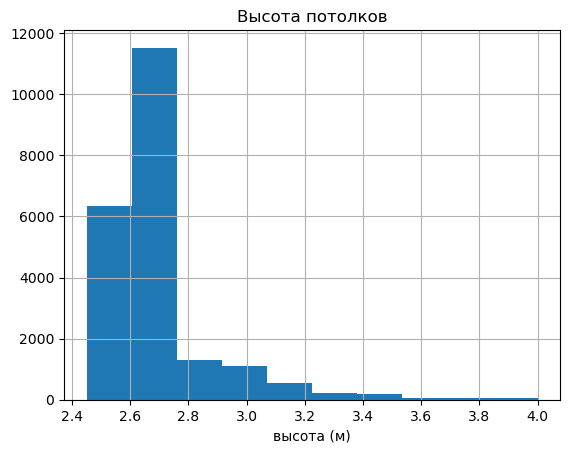

In [207]:
df['ceiling_height'].hist(bins=10)
plt.title('Высота потолков')
plt.xlabel('высота (м)')
plt.show()

In [208]:
df['ceiling_height'].median()

2.65

Стандартная высота потолка: 2,65 м.

- этаж

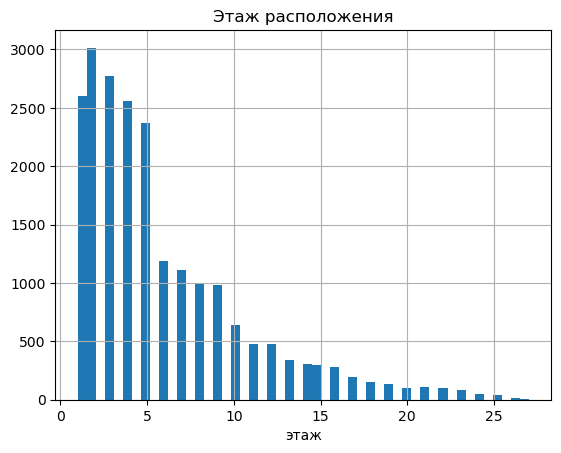

In [209]:
df['floor'].hist(bins=50)
plt.title('Этаж расположения')
plt.xlabel('этаж')
plt.show()

Большинство квартир расположены на первых трех этажах в пятиэтажках.

- тип этажа («первый», «последний», «другой»)

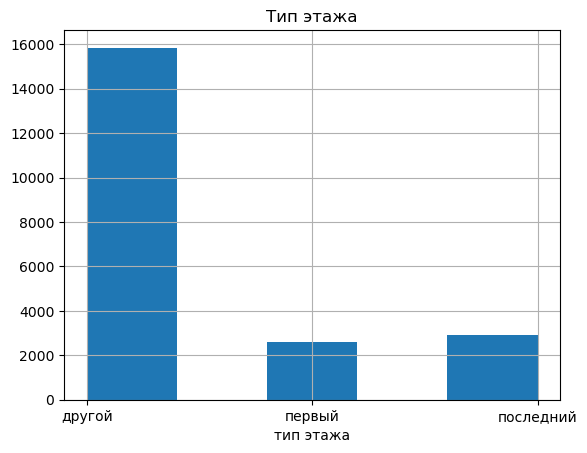

In [210]:
df['floor_type'].hist(bins=5)
plt.title('Тип этажа')
plt.xlabel('тип этажа')
plt.show()

Квартир на первом и последнем этаже меньше, чем на других этажах (что довольно логично).

- этажность дома

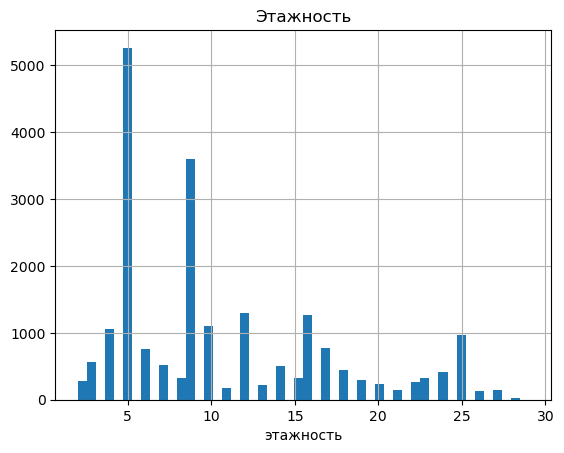

In [211]:
df['floors_total'].hist(bins=50)
plt.title('Этажность')
plt.xlabel('этажность')
plt.show()

Большинство домов - на 5 и 9 этажей.

- близость к центру города

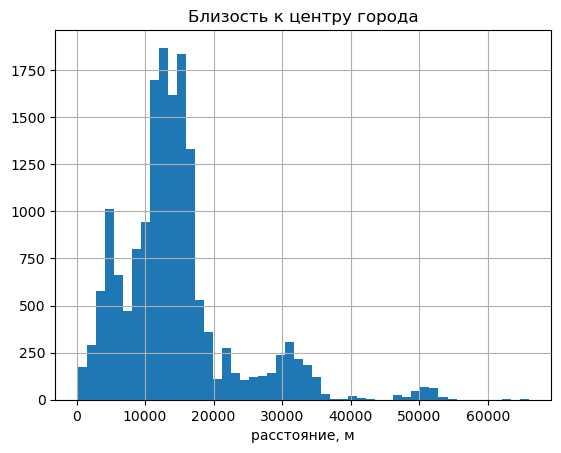

In [212]:
df['cityCenters_nearest'].hist(bins=50)
plt.title('Близость к центру города')
plt.xlabel('расстояние, м')
plt.show()

Большинство квартир находятся в 12-15 км от центра города.

- o	расстояние до ближайшего аэропорта

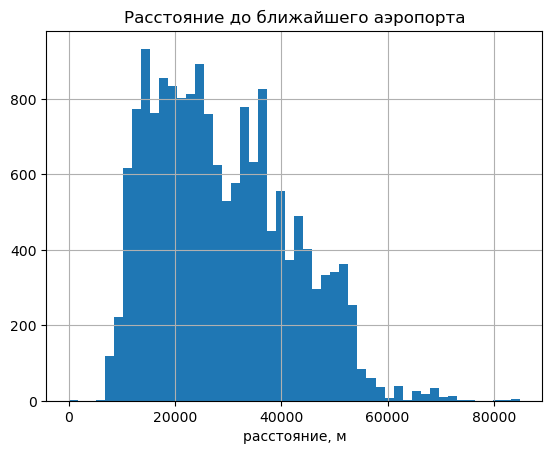

In [213]:
df['airports_nearest'].hist(bins=50)
plt.title('Расстояние до ближайшего аэропорта')
plt.xlabel('расстояние, м')
plt.show()

Разброс значений расстояния до аэропорта больше, чем до центра города.<br>
Расстояния до аэропорта распределены более плавно и преимущественно находятся в диапазоне от 10 до 50 км.

- расстояние до ближайшего парка

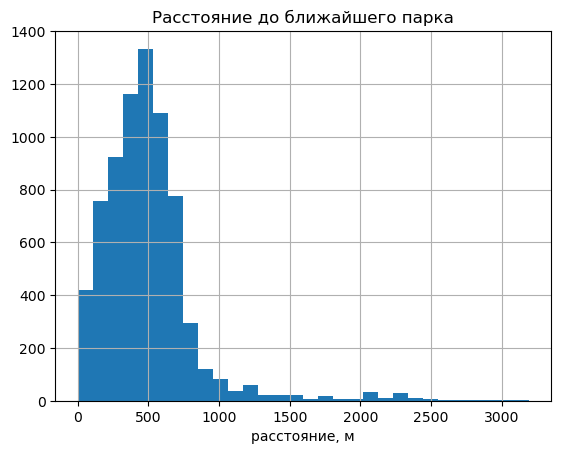

In [214]:
df['parks_nearest'].hist(bins=30)
plt.title('Расстояние до ближайшего парка')
plt.xlabel('расстояние, м')
plt.show()

В большинстве случаев парк в радиусе 600 м.

- день публикации объявления

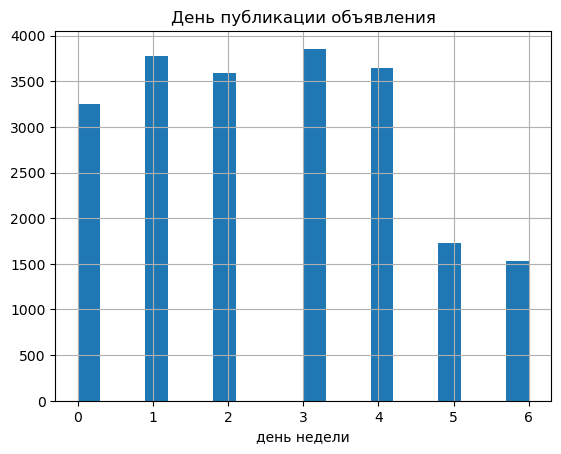

In [215]:
df['day'].hist(bins=20)
plt.title('День публикации объявления')
plt.xlabel('день недели')
plt.show()

Объявления обычно размещают в будние дни.

- месяц публикации объявления

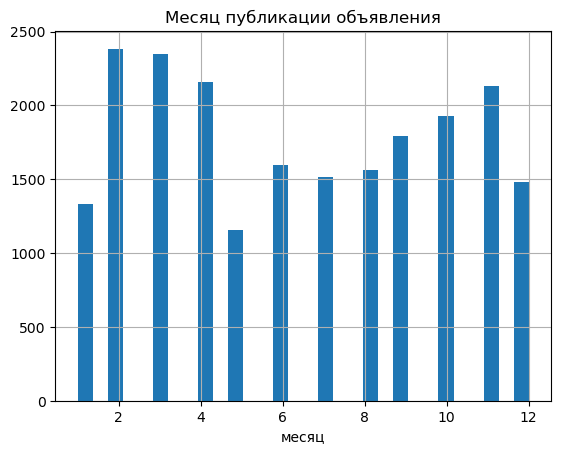

In [216]:
df['month'].hist(bins=30)
plt.title('Месяц публикации объявления')
plt.xlabel('месяц')
plt.show()

Пик подачи объявлений - февраль-март и октябрь-ноябрь. Минимумы в январе и мае.

#### Длительность размещения объявлений

Изучим, как быстро продавались квартиры (но не более двух лет).

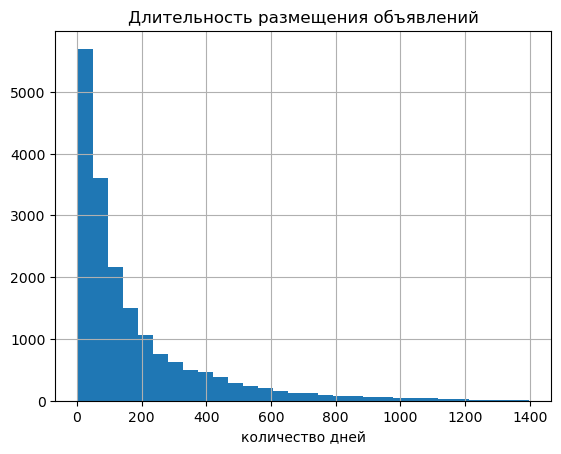

In [217]:
df['days_exposition'].hist(bins=30)
plt.title('Длительность размещения объявлений')
plt.xlabel('количество дней')
plt.show()

In [218]:
df['days_exposition'].mean()

179.2992842150584

In [219]:
df['days_exposition'].median()

95.0

In [220]:
df['days_exposition'].describe()

count    18581.000000
mean       179.299284
std        216.236694
min          3.000000
25%         45.000000
50%         95.000000
75%        230.000000
max       1396.000000
Name: days_exposition, dtype: float64

Обычно квартиру продают за 3 месяца. Четверть объявлений закрывают за полтора месяца, 75% от всех объявлений открыты не дольше 7,5 месяцев.<br>
Отдельные объявления, отсеянные ранее, висят больше 4 лет. Если квартиру не купили за 4 года - это повод задуматься о причинах.

#### Влияние на стоимость объекта

Влияние различных факторов на общую стоимость объекта:

1) общая площадь

0.7592550435452468


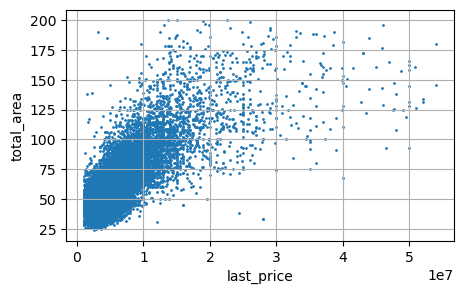

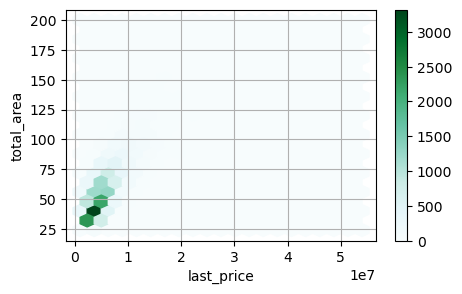

In [221]:
print(df['last_price'].corr(df['total_area']))
df.plot(x='last_price', y='total_area', kind='scatter', 
        grid=True, figsize=(5,3), s=1);
df.plot(x='last_price', y='total_area', kind='hexbin', 
        gridsize=20, sharex=False, grid=True, figsize=(5,3));

2) жилая площадь

0.6492848476464055


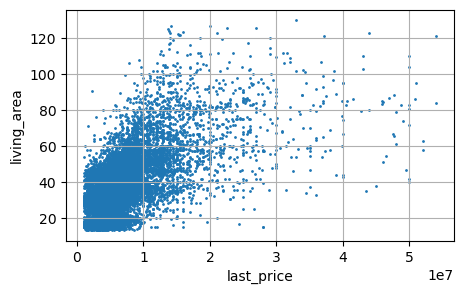

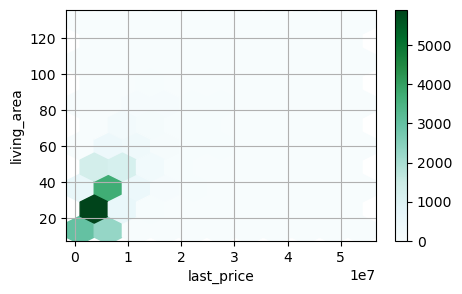

In [222]:
print(df['last_price'].corr(df['living_area']))
df.plot(x='last_price', y='living_area', kind='scatter',
        grid=True, figsize=(5,3), s=1);
df.plot(x='last_price', y='living_area', kind='hexbin', 
        gridsize=10, sharex=False, grid=True, figsize=(5,3));

3) площадь кухни

0.5770580527843708


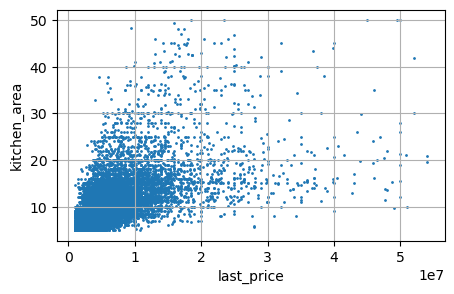

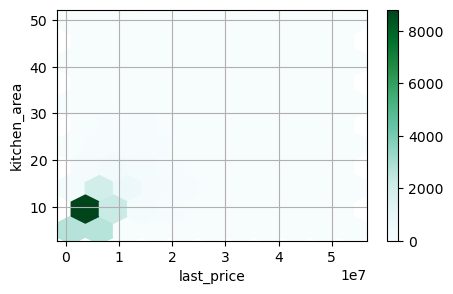

In [223]:
print(df['last_price'].corr(df['kitchen_area']))
df.plot(x='last_price', y='kitchen_area', kind='scatter', 
        grid=True, figsize=(5,3), s=1);
df.plot(x='last_price', y='kitchen_area', kind='hexbin', 
        gridsize=10, sharex=False, grid=True, figsize=(5,3));

На стоимость квартиры в наибольшей степени влияет общая площадь.

4) количество комнат

0.45053135503197056


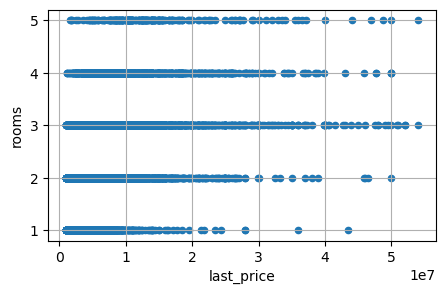

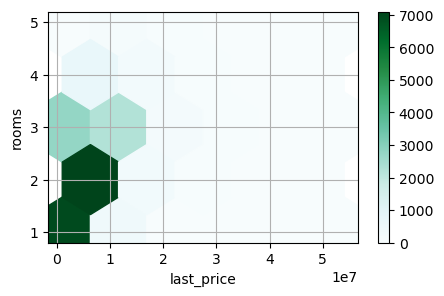

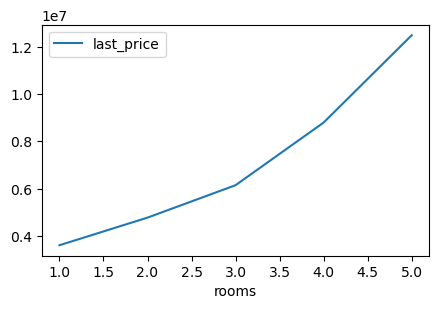

In [224]:
print(df['last_price'].corr(df['rooms']))
df.plot(x='last_price', y='rooms', kind='scatter', 
        grid=True, figsize=(5,3));
df.plot(x='last_price', y='rooms', kind='hexbin', 
        gridsize=5, sharex=False, grid=True, figsize=(5,3));
df.pivot_table(index='rooms', values='last_price', 
               aggfunc='median').plot(y='last_price', figsize=(5,3));

5) этаж

0.060672741221711735


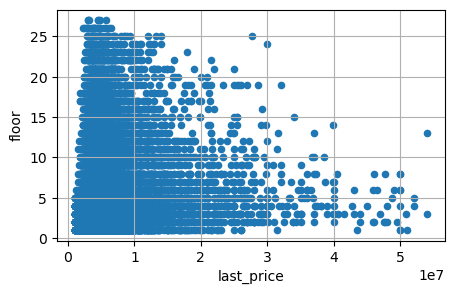

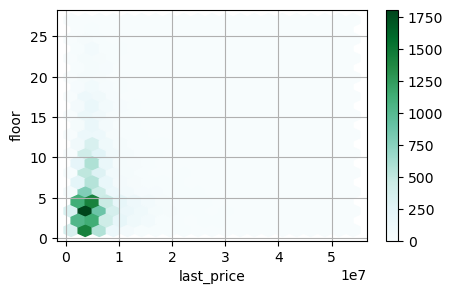

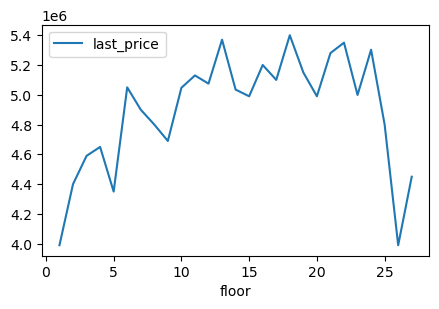

In [225]:
print(df['last_price'].corr(df['floor']))
df.plot(x='last_price', y='floor', kind='scatter', 
        grid=True, figsize=(5,3));
df.plot(x='last_price', y='floor', kind='hexbin', 
        gridsize=20, sharex=False, grid=True, figsize=(5,3));
df.pivot_table(index='floor', values='last_price', 
               aggfunc='median').plot(y='last_price', figsize=(5,3));

6) дата размещения (день недели, месяц, год)

-0.01831941286038183


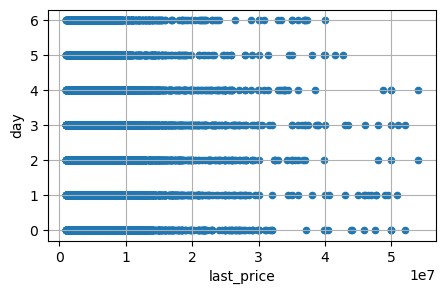

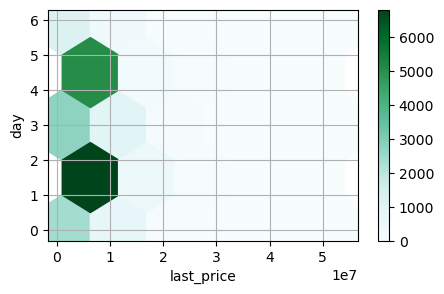

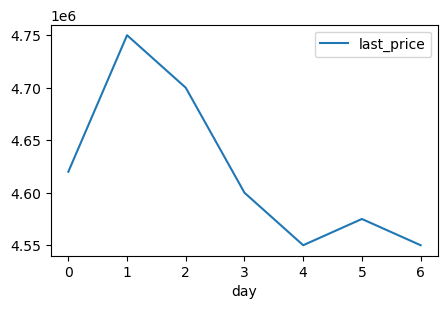

In [226]:
print(df['last_price'].corr(df['day'])) #день недели
df.plot(x='last_price', y='day', kind='scatter', grid=True, figsize=(5,3));
df.plot(x='last_price', y='day', kind='hexbin', gridsize=5, sharex=False, grid=True, figsize=(5,3));
df.pivot_table(index='day', values='last_price', aggfunc='median').plot(y='last_price', figsize=(5,3));

-0.004574735624983662


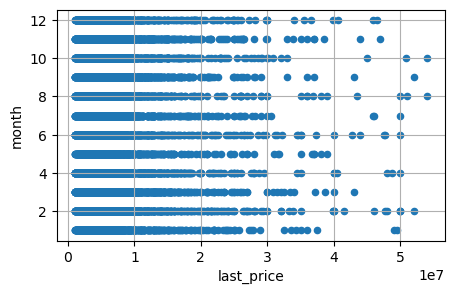

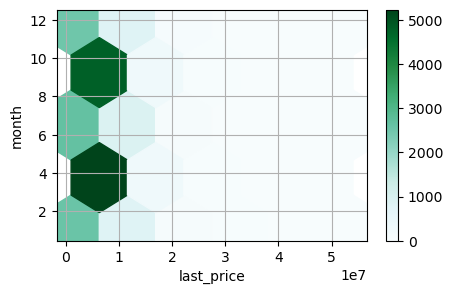

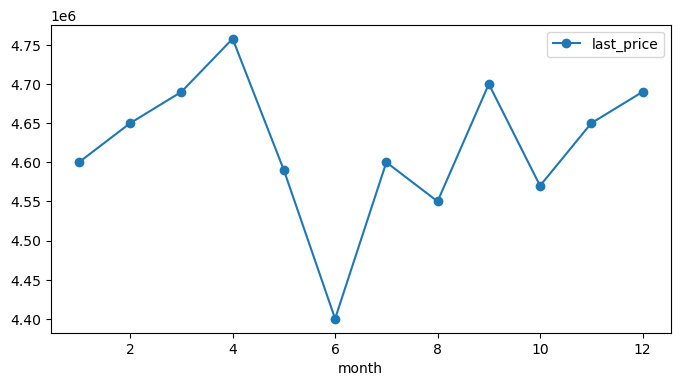

In [227]:
print(df['last_price'].corr(df['month'])) #месяц
df.plot(x='last_price', y='month', kind='scatter', grid=True, figsize=(5,3));
df.plot(x='last_price', y='month', kind='hexbin', gridsize=5, sharex=False, grid=True, figsize=(5,3));
df.pivot_table(index='month', values='last_price', aggfunc='median').plot(y='last_price', style='o-', figsize=(8,4));

-0.03700641032861937


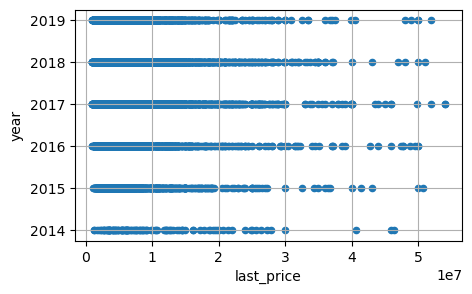

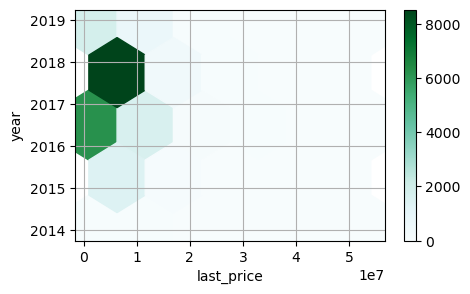

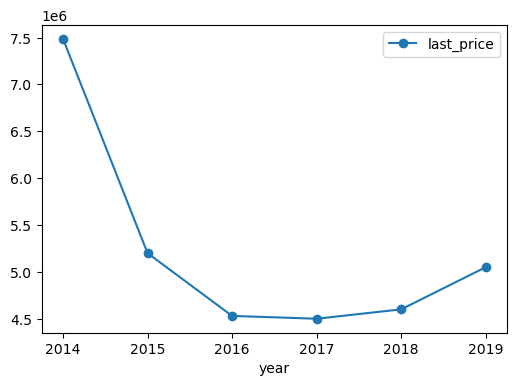

In [228]:
print(df['last_price'].corr(df['year'])) #год
df.plot(x='last_price', y='year', kind='scatter', 
        grid=True, figsize=(5,3));
df.plot(x='last_price', y='year', kind='hexbin', 
        gridsize=5, sharex=False, grid=True, figsize=(5,3));
df.pivot_table(index='year', values='last_price', 
               aggfunc='median').plot(y='last_price', style='o-', figsize=(6,4));

Общая стоимость квартиры в наибольшей степени зависит от общей площади. Вместе с ней обычно растет жилая площадь, площадь кухни и количество комнат. <br>

На первом этаже квартиры дешевле. Остальные этажи не сильно различаются по цене, но квартиры в многоэтажных домах обычно дороже. <br>

Зависимость (корреляция) между стоимостью квартиры и временем размещения объявления практически полностью отсутствует. Но в среднем квартиры дешевле с четверга по субботу, в июне и в 2016 году.

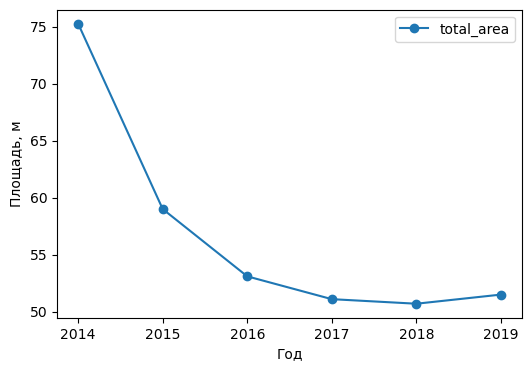

In [229]:
# медианная площадь продаваемых квартир по годам
df.pivot_table(index='year', values='total_area', 
               aggfunc='median').plot(y='total_area', style='o-', figsize=(6,4));
plt.xlabel('Год')
plt.ylabel('Площадь, м')
plt.show()


Раньше квартиры были больше.

#### Топ 10 мест для покупки квартиры

Посмотрим на среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [230]:
place = (
    df.pivot_table(index='locality_name', values='kvm_cost', aggfunc=['count','mean'])
    .sort_values(by=('count', 'kvm_cost'), ascending=False)
    .head(10).round(2)
)
place

,count,mean
,kvm_cost,kvm_cost
locality_name,,
Санкт-Петербург,14313,111304.49
Мурино,502,84856.60
поселок Шушары,407,77690.63
Всеволожск,360,68642.26
Пушкин,339,102404.82
Колпино,320,75115.10
поселок Парголово,305,89777.08
Гатчина,283,68892.00


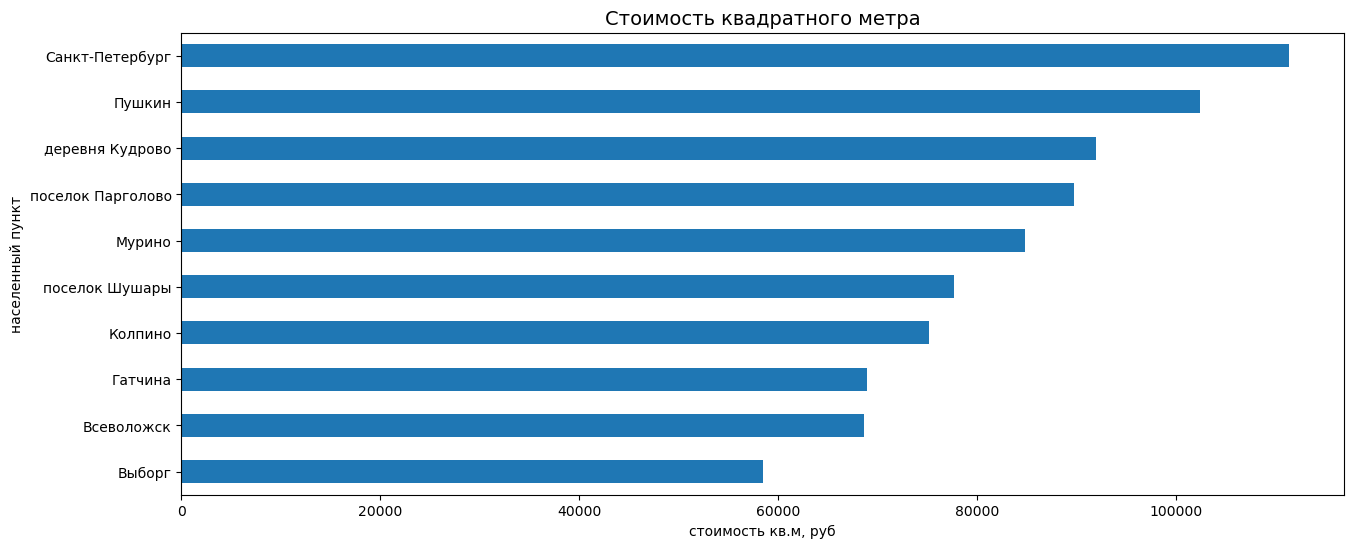

In [231]:
(
    place
    .sort_values(by=('mean', 'kvm_cost'), ascending=True)
    .head(10).round(2)
    ['mean', 'kvm_cost']
).plot(kind='barh', figsize=(15,6))
plt.title('Стоимость квадратного метра', fontsize=14)
plt.xlabel('стоимость кв.м, руб')
plt.ylabel('населенный пункт')
plt.show()

По цене за квадратный метр с отрывом выигрывает Санкт-Петербург - более 111 тысяч за кв.м. Замыкает десятку Выборг - 58 тысяч за кв.м

#### Цена километра

Опишим, как стоимость объектов зависит от расстояния до центра Санкт-Петербурга.

In [232]:
df.sample()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kvm_cost,day,month,year,floor_type,center_city_km
7674,8466,20,4800000.0,60.0,2017-12-08,3,2.5,9,40.0,3,...,NaN,0,NaN,157.0,80000.0,4,12,2017,другой,27.0


In [233]:
df[df['locality_name'] == 'Санкт-Петербург']['center_city_km'].value_counts()

12.0    1497
15.0    1473
13.0    1344
14.0    1199
16.0    1189
11.0    1111
17.0     836
5.0      779
10.0     666
4.0      589
8.0      556
9.0      545
6.0      522
7.0      366
3.0      303
2.0      244
18.0     243
22.0     191
1.0      155
19.0     145
21.0     101
23.0      79
26.0      35
24.0      25
25.0      19
20.0      19
0.0       16
28.0       7
29.0       6
27.0       2
Name: center_city_km, dtype: int64

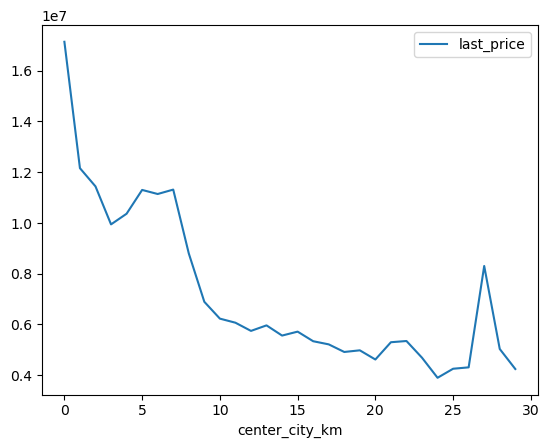

In [234]:
#среднее значение стоимости квартир, находящихся на определенном расстоянии от центра
(
    df.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='center_city_km', values='last_price', aggfunc='mean') 
    .plot()
);

Самые дорогие квартиры - в центре города. После 10 км от центра разница в цене становится меньше.

Изучим выброс на 27-ом километре.

In [235]:
print(len(df[(df['locality_name'] == 'Санкт-Петербург')&(df['center_city_km']==27)]))
print(df[(df['locality_name'] == 'Санкт-Петербург')&(df['center_city_km']==27)
        ]['last_price'].describe())
display(df[(df['locality_name'] == 'Санкт-Петербург')&(df['center_city_km']==27)])

2
count    2.000000e+00
mean     8.300000e+06
std      8.555992e+06
min      2.250000e+06
25%      5.275000e+06
50%      8.300000e+06
75%      1.132500e+07
max      1.435000e+07
Name: last_price, dtype: float64


,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kvm_cost,day,month,year,floor_type,center_city_km
669,748,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,...,1496.0,0,NaN,128.0,193918.92,1,11,2017,другой,27.0
5405,5961,6,2250000.0,32.0,2018-02-27,1,2.65,2,16.5,2,...,NaN,0,NaN,178.0,70312.50,1,2,2018,последний,27.0


Выброс вызван дорогим объектом №669

### Общий вывод

В исходных данных содержится 23699 строк и 22 столбца.<br>
В 14 столбцах содержатся пропущенные значения.<br>

Пропуски заполнены следующим образом:
- высота потолков: медиана;
- этажность дома: типовая этажность 5, 9, 12, 17, 26 в зависимости от этажа квартиры;
- жилая площадь: медианное значение с коэффициентом 0,9 для групп по общей площади: 0-25, 25-35, 35-50, 50-60, 60-80, 80-100, 100-125, 125+ кв.м.;
- апатртаменты: значением False;
- площадь кухни: медиана с коэффициентом 0,85 для групп по общей площади: 0-25, 25-35, 35-45, 45-60, 60-80, 80-120, 120+ кв.м.;
- число балконов: значением 0;
- название населённого пункта: строки удалены;
- расстояние до аэропорта и центра города: не заполнены;
- число парков и водоемов в радиусе 3 км: значением 0;
- расстояние до ближайшего парка, пруда (м): не заполнены;
- время размещение объявления: не заполнены.<br>

Изменение типов данных:
- в столбце, содержащем дату публикации объявления, тип данных изменен на datetime;
- в столбцах, содержащих целые значения, тип данных изменен на int (целые значения).<br>

Явные дубликаты в данных отсутствуют.<br>

В названиях населенных пунктов присутствуют неявные дубликаты.<br>
Убрано 42 неявных дубликата. Явных дубликатов при этом не появилось.<br>

Устранены редкие и выбивающиеся значения (аномалии) во всех столбцах (удалено 9,78% исходных данных).<br>
В значения количества комнат и высоты потолков внесены дополнительные изменения.<br>

Результаты исследовательского анализа данных:
- Большинство квартир имеют площадь от 35 до 65 кв.м и примерно делятся на три группы: 35 кв.м, 45 кв.м, 55 кв.м.
- Выделяются три группы значений жилой площади: 18 м, 30 м, 45 м. Указанные группы связаны с количеством комнат. Чем больше комнат, тем больше жилая площадь квартиры.
- Большинство кухонь имеют площадь около 9,5 кв.м.
- Средняя (медианная) цена квартиры составляет 4,6 млн.
- Чем меньше комнат - тем больше предложение на рынке жилой недвижимости.
- Стандартная высота потолка: 2,65 м.
- Большинство квартир расположены на первых трех этажах в пятиэтажках.
- Большинство домов - на 5 и 9 этажей.
- Большинство квартир находятся в 12-15 км от центра города.
- Разброс значений расстояния до аэропорта больше, чем до центра города. Расстояния до аэропорта распределены более плавно и преимущественно находятся в диапазоне от 10 до 50 км.
- В большинстве случаев парк в радиусе 600 м.
- Объявления обычно размещают в будние дни.
- Пик подачи объявлений - февраль-март и октябрь-ноябрь. Минимумы в январе и мае.

Влияние различных факторов на общую стоимость объекта:
- Общая стоимость квартиры в наибольшей степени зависит от общей площади. Вместе с ней обычно растет жилая площадь, площадь кухни и количество комнат.
- На первом этаже квартиры дешевле. Остальные этажи не сильно различаются по цене, но квартиры в многоэтажных домах обычно дороже.
- Зависимость (корреляция) между стоимостью квартиры и временем размещения объявления практически полностью отсутствует. Но в среднем квартиры дешевле с четверга по субботу, в июне и в 2016 году.
- По цене за квадратный метр с отрывом выигрывает Санкт-Петербург - более 111 тысяч за кв.м. Замыкает десятку Выборг - 58 тысяч за кв.м
- Самые дорогие квартиры - в центре города. После 10 км от центра разница в цене становится меньше.
